# Сборный проект.

## Описание проекта.


Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

Импортируем библиотеки для начала работы.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

In [2]:
try:
    data = pd.read_csv('/datasets/games.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')
pd.set_option('display.max_columns', None)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Сохраним в переменную old_data копию оригинала датасета.

In [3]:
old_data = data.copy()

Выведем на экран первые пять строк датасета и изучим особенности данных.

In [4]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Построим гистограммы для столбцов датасета методом .hist()

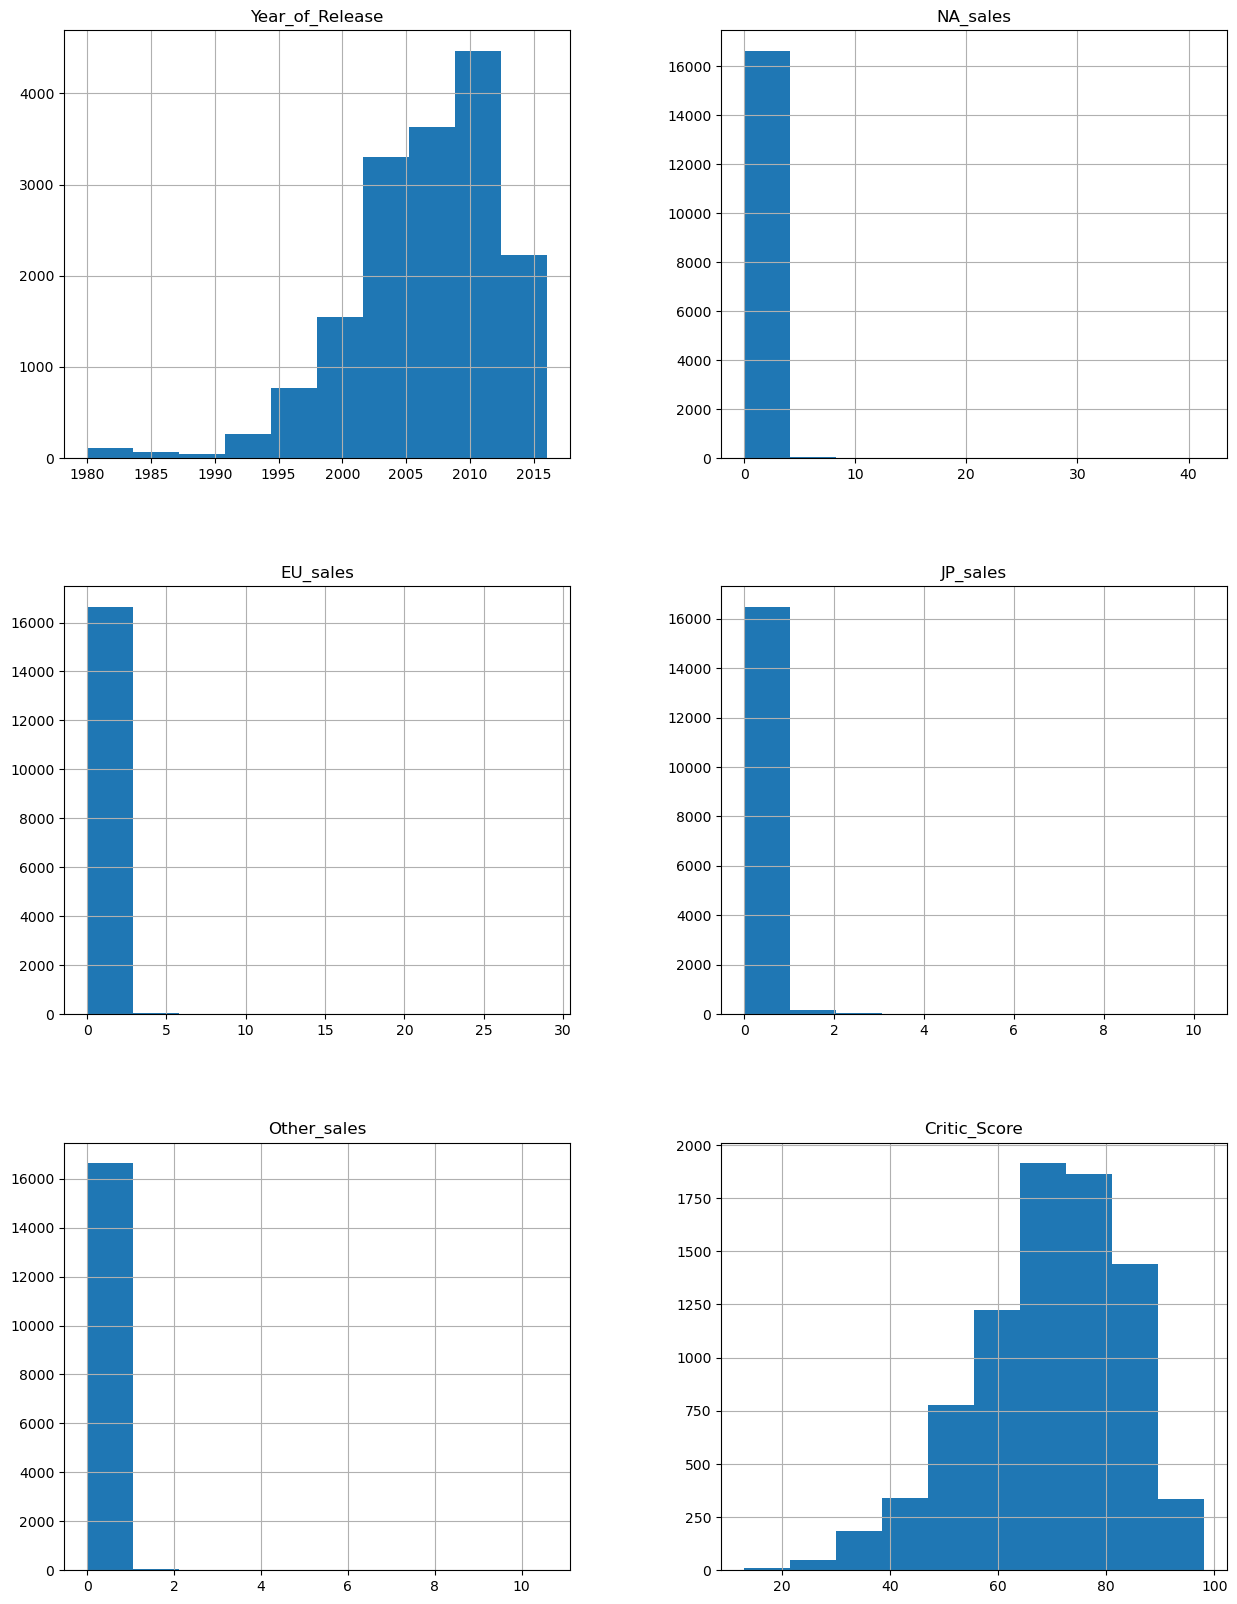

In [5]:
data.hist(figsize=(15, 20));

## Предообработка данных.

Выполним предообработку данных. Для начала приведем столбцы к нижнему регистру с помощью метода str.lower().

In [6]:
data.columns = data.columns.str.lower()

Преобразуем данные в столбце year_of_release в формат float. 

In [7]:
data['year_of_release'] = data['year_of_release'].astype(float)

Воспользуемся методом duplicated().sum() и проверим присутствуют ли в датасете строки дубликаты.

In [8]:
data.duplicated().sum()

0

В датасете дубликаты не зафиксированы. Продолжаем обработку дальше.

Воспользуемся методом isna().sum() и определим количество пропусков в каждом из столбцов датасета. 

In [9]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

Видим,что в датасете в некоторых столбцах присутствуют пропущенные значения. 
Существуют различные причины появления пропусков в исходных данных.
Человеческий фактор(неправильный ввод(ошибки), неправильная выгрузка данных).
Также причинами появления пропусков в данных могут быть проблемы технического характера(падение серверов, сбой в работе ПО).
Стоит помнить, что в нашем случае пропуски также могут иметь естественный характер. Например в столбце rating. Есть ряд игр, которым комиссия не провела процедуру присвоения рейтинга.

Далее изучим пропущенные значения в каждом столбце более детально и решим заполнять пропуски или нет.

1) Количество пропусков в столбцах name и genre незначительное, пропуски не заполняем.

2) Для стобца year_of_release количество пропусков равно 269. В данном столбце указан год выхода игры, заполнять данные пропуски средним/медианным значениями не стоит, так как на выходе можем получить недостоверные данные.

3) Столбец critic_score отражает оценку поставленную критиками. Количество пропусков слишком большое, лучше не заполнять их недостовернными данными иначе можно исказить итоговые результаты исследования.

4) Столбец user_score отражает оценку поставленную пользователями. В данном столбце также слишком много пропусков, по аналогии с предыдущим пунктом не заполняем значения.

5) В столбце rating содержатся данные о возрастном ограничении конкретной игры. С пропусками в данном столбце стоит быть аккуратнее, можем заполнить пропущенные значения - 'unknown'. 

Воспользуемся методом describe() и проверим присутствуют ли в столбце critic_score аномальные значения.

In [10]:
data['critic_score'].describe()

count    8137.000000
mean       68.967679
std        13.938165
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: critic_score, dtype: float64

Минимальный рейтинг - 13.00 , а максимальный 98.00. Данные значения вполне корректны, аномалий не выявленно.

Применим метод unique() и изучим все уникальные значения в столбце user_score.

In [11]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

В столбце присутствует значения TBD (to be determined = будет определено). Используется, если какая-то информация еще не определена или решение по вопросу не принято. Акроним служит для отметки неясностей или пропусков, которые надо заполнить, в информации требований. 

Заменим значения TBD на NaN с помощью метода str.replace

In [12]:
data['user_score'] = data['user_score'].str.replace('tbd','NaN')

Изменим тип столбца user_score c object на float64 с помощью метода to_numeric.

In [13]:
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce').astype('float')

Воспользуемся методом unique() и изучим значения в столбце rating.

In [14]:
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Используемся метод value_counts и посмотрим как часто в столбце встречается то или иное значение рейтинга. 

In [15]:
data['rating'].value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: rating, dtype: int64

Как видно рейтинги: EC, RP, K-A, AO - составляют пренебрежимо малую долю из общей совокупности данных столбца. Удалим их.

In [16]:
data = data[(data['rating'] != 'EC') & (data['rating'] != 'RP')
           & (data['rating'] != 'K-A') & (data['rating'] != 'AO')]

В столбце присутствуют пропущенные значения. Заполним пропуски методом fillna на значение 'unknown'.

In [17]:
data['rating'] = data['rating'].fillna('unknown')

Воспользуемся методом isna().sum() и убедимся что выбранные нами пропущенные значения заполнены.

In [18]:
data.isna().sum()

name                  2
platform              0
year_of_release     267
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8568
user_score         9117
rating                0
dtype: int64

Воспользуемся методом shape и посмотрим были ли потеряны данные в результате предообработки.

In [19]:
data.shape[0] / old_data.shape[0]

0.9991026024528866

Потери данных составили менее 1%.

### Результаты предообработки.

В результате предообработки данных была проведена работа с датасетом:

1) Названия всех столбцов приведены к нижнему регистру.
2) Формат столбца year_of_release изменен на int64.
3) В столбце user_score изменены значения tbd' на 'NaN'.
4) Столбец user_score приведен к числовому виду. 
5) Из столбца rating удалены значения, которыми можно пренебречь. 
6) Пропуски в столбце rating заполнены значением 'unknown'.

Далее посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец (total_sales)

In [20]:
data['total_sales'] = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis=1)

## Исследовательский анализ данных.

Проведем исследовательский анализ данных. Начнем с анализа количества выпущенных игр в разные годы. Воспользуемся методом .groupby() и count() и подсчитаем количество игр по годам.

In [21]:
data.groupby('year_of_release')['year_of_release'].count()

year_of_release
1980.0       9
1981.0      46
1982.0      36
1983.0      17
1984.0      14
1985.0      14
1986.0      21
1987.0      16
1988.0      15
1989.0      17
1990.0      16
1991.0      41
1992.0      43
1993.0      62
1994.0     121
1995.0     219
1996.0     262
1997.0     287
1998.0     379
1999.0     338
2000.0     350
2001.0     482
2002.0     829
2003.0     775
2004.0     762
2005.0     936
2006.0    1006
2007.0    1197
2008.0    1427
2009.0    1425
2010.0    1251
2011.0    1134
2012.0     653
2013.0     544
2014.0     581
2015.0     606
2016.0     502
Name: year_of_release, dtype: int64

Построим гистограмму для столбца year_of_release.

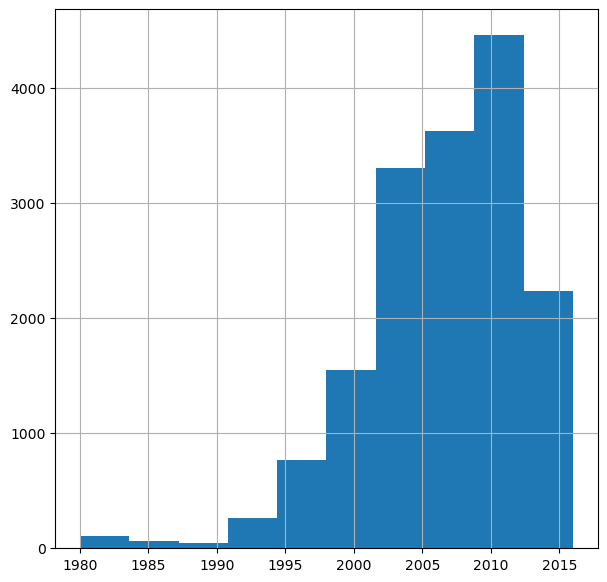

In [22]:
data['year_of_release'].hist(figsize=(7, 7));

Как видно на гистограмме индустрия разработки компьютерных игр начала ускоренный рост в конце 90х годов и достигла своего пика в 2010-2012. Далее произошел спад в два раза.

### ТОП 10 самых популярных платформ.

Попробуем определить топ 10 платформ и количество игр выпущенных на них в разные года. Для этого создадим переменную top_10_platforms куда запишем сводную таблицу. Отсортируем значения по убыванию. Далее напишем функцию, которая будет производить срез данных по платформе и сформирует сводную таблицу с годом выпуска и итоговыми продажами. Затем построим столбчатую диаграмму на основе получившейся таблицы. 

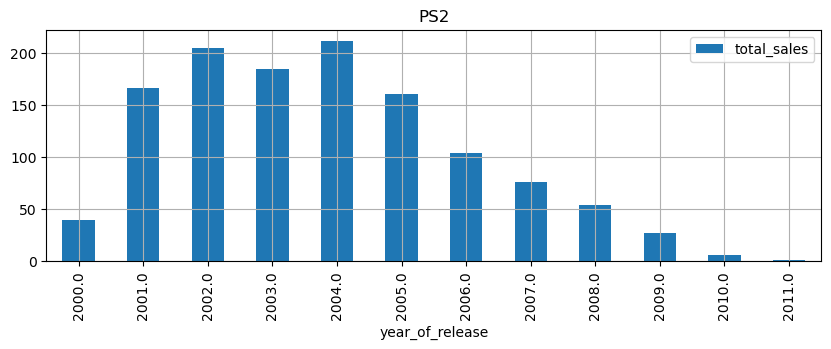

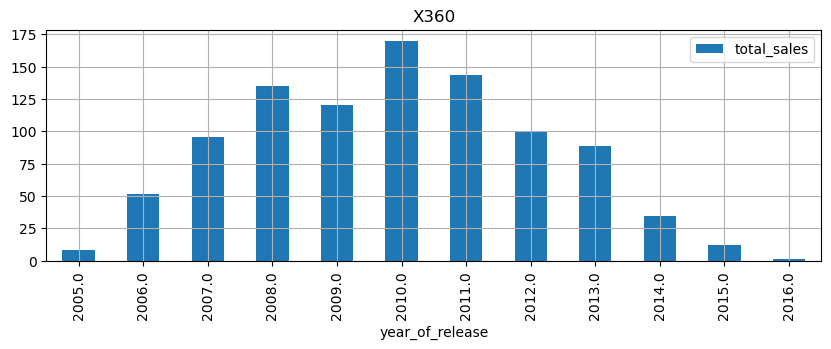

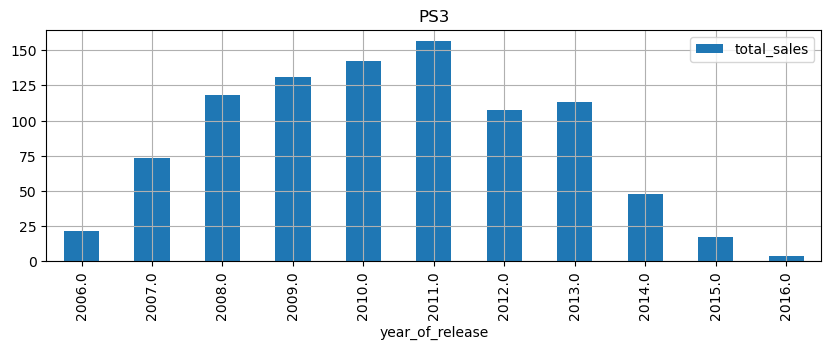

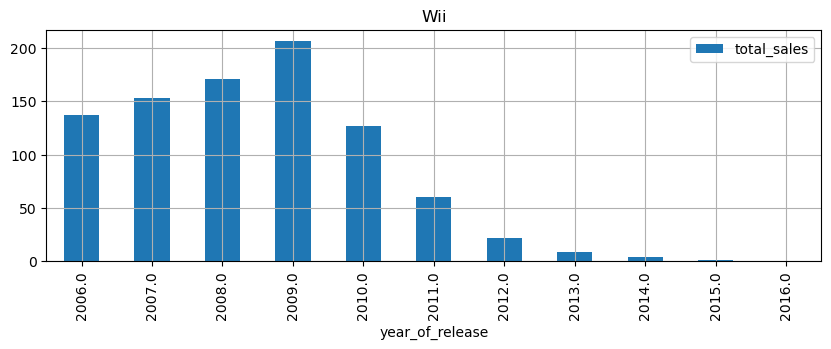

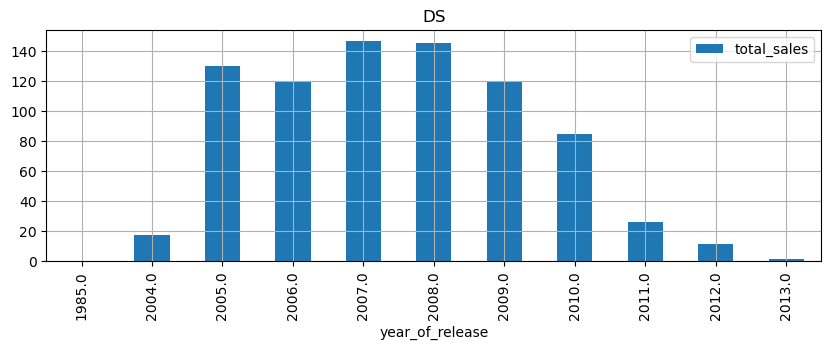

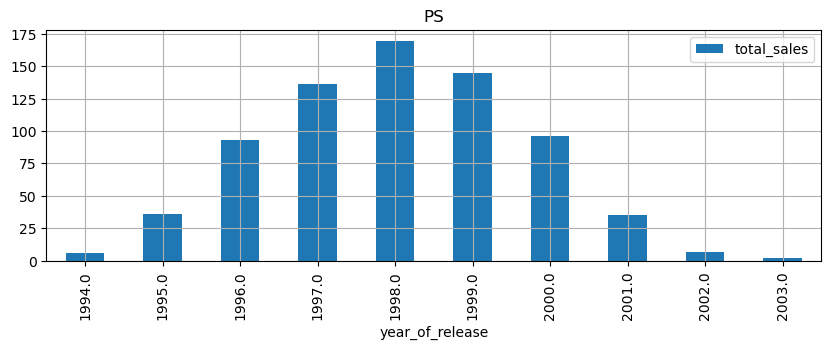

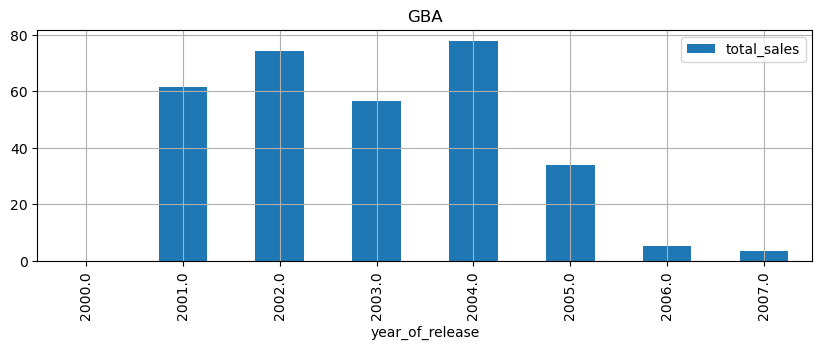

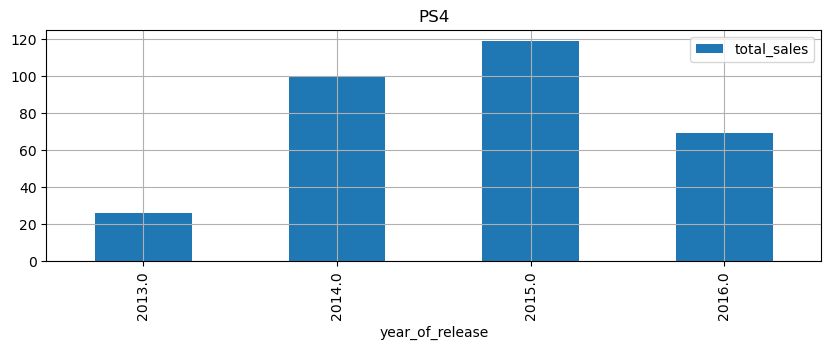

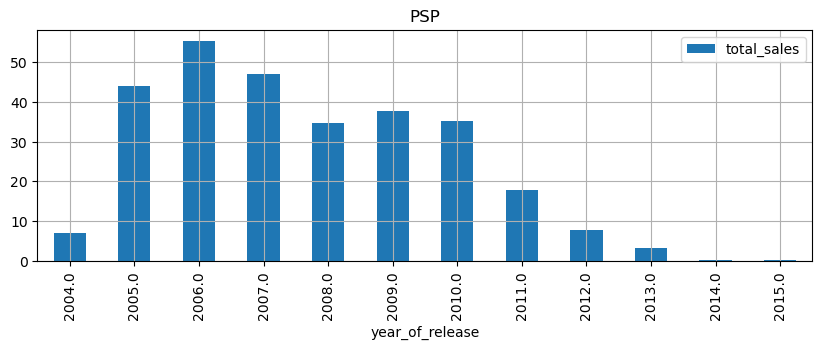

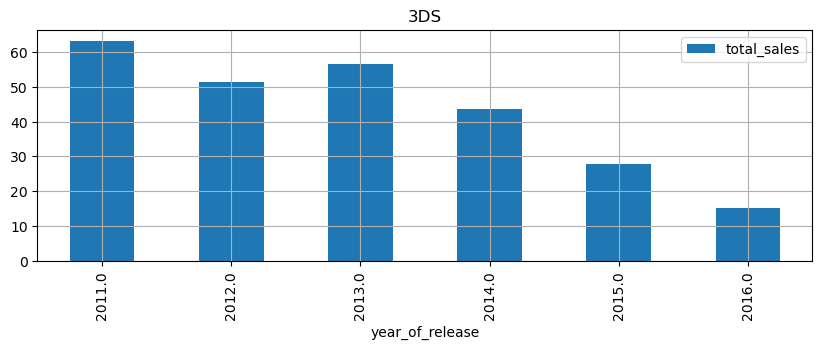

In [23]:
top_10_platforms = data.pivot_table(index='platform', values='total_sales', aggfunc='sum')
top_10_platforms.columns=['sum']
top_10_platforms = top_10_platforms.sort_values('sum', ascending = False).head(10)
top_10_platforms = top_10_platforms.reset_index() 
for i in top_10_platforms['platform']:
    data.query('platform ==@i').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(kind='bar', grid=True, figsize=(10, 3))
    plt.title(i)

Исходя из полученных данных можно сделать вывод, что средний срок жизни платформы составляет ~ 10 лет. Основная особенность что пика продаж платформа достигает в первые 5 лет, далее идёт спад и завершение цикла жизни платформы. 
Исключением является PC, так как это не только платформа для игр , но и универсальный инструмент для работы и мультимедиа.

Определим актуальный период для исследования. Так как целью задания является построить прогноз на 2017 год, то возьмем данные за пятилетний период с 2012 по 2016 год. Основной критерий на основании чего выбран данный период: 

Данные не слишком старые. Нет смысла использовать данные 80х,90х и 00х годов, так как сменилось несколько поколений консолей и в целом индустрия игр значительно выросла за несколько десятилетий.

### ТОП самых популярных платформ за актуальный период.

Сделаем срез данных с помощью метода query с 2012 года. Посчитаем суммарные продажи по платформам и отсортируем значения по убыванию. Далее построим столбчатую диаграмму.

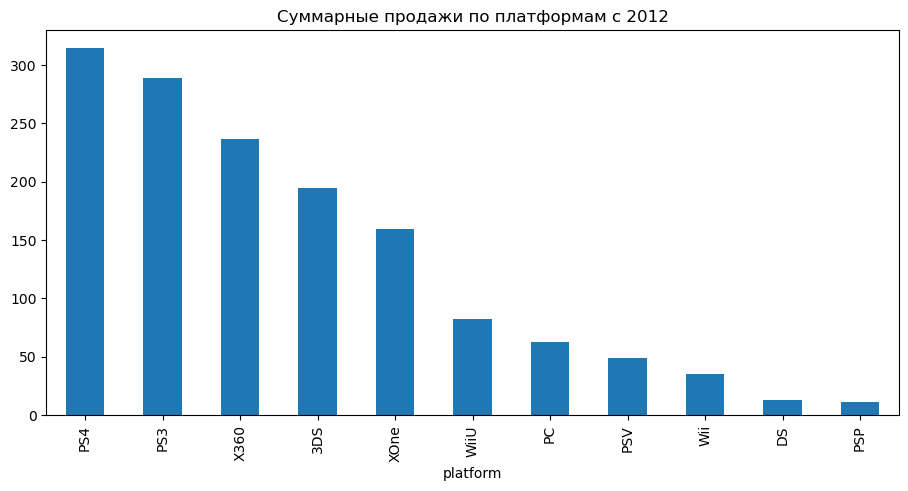

In [24]:
actual_period = data.query('year_of_release>=2012')
actual_period.groupby('platform')['total_sales'].sum().sort_values(ascending=False).plot(figsize=(11,5),kind="bar",title='Суммарные продажи по платформам с 2012');

Топ 3 самых прибыльных платформ за период с 2012 по 2016 год: PS4, PS3, X360.

In [25]:
data['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

<div class="alert alert-info">
<b>Комментарий студента:</b>
<br> Построим boxplot используя срез данных для актуального периода (с 2012 по 2016 год). Изменим параметр ylim для более наглядного отображения медианы.
</div>

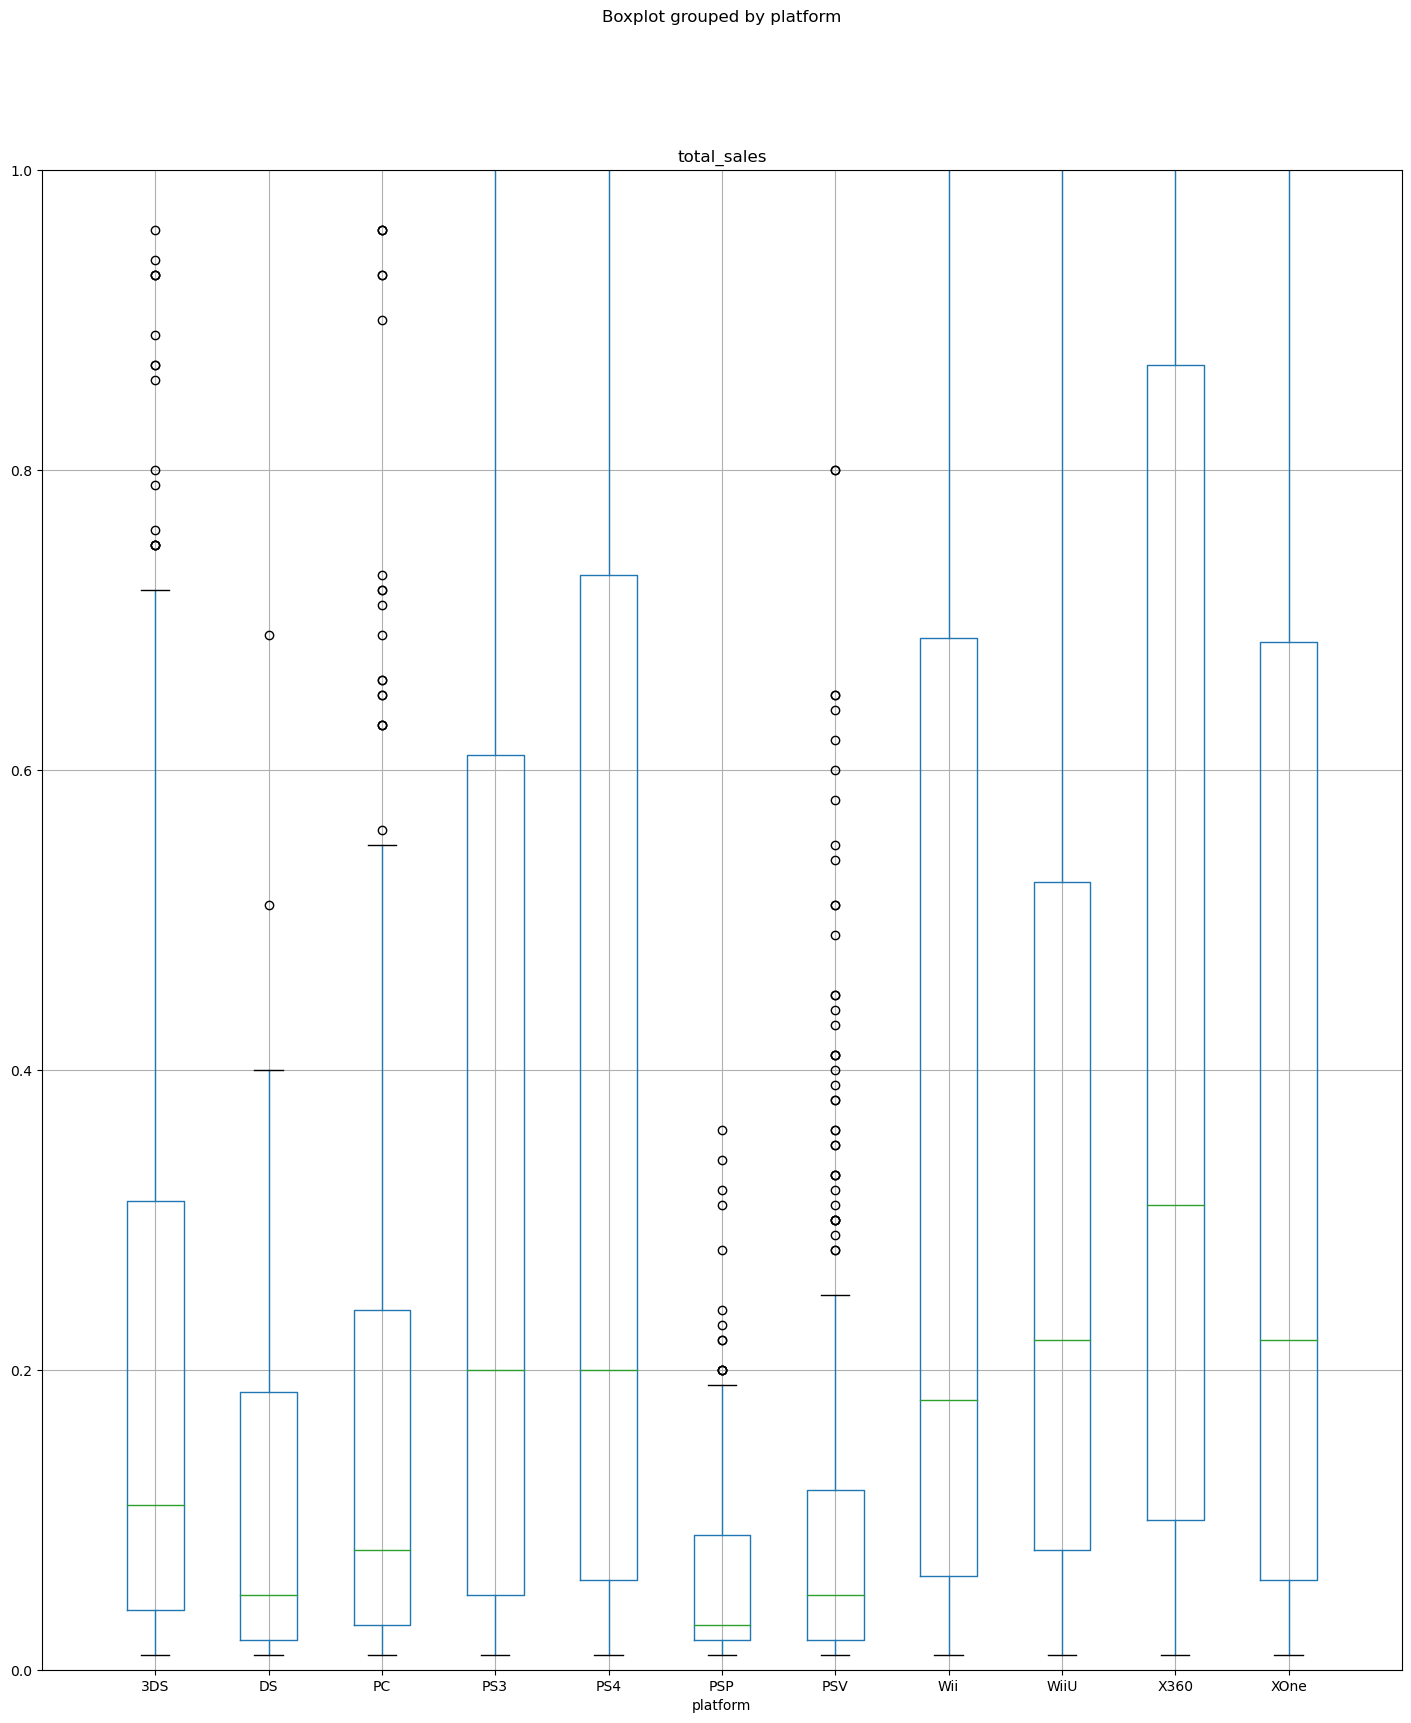

In [26]:
actual_period.boxplot(by='platform', column='total_sales', figsize=(17,20))

plt.xlim(0, 12)
plt.ylim(0, 1)
plt.show();

На графике можно выявить платформы с высокими продажами в рамках их "цикла жизни", например консоли 3DS, DS, PSP и другие.

### Определение корреляции.

Возьмем для примера консоль PS4 и построим диаграмму рассеяния и выявим взаимосвязь оценки пользователей и итоговых продаж. 

Возьмем список популярных консолей в актуальном периоде и рассчитаем коэффициенты корреляция для оценки критиков/пользователей.
Список популярных консолей: PC, PS3, PS4, Wii, WiiU, X360, XOne. 

In [27]:
actual_platform_PC = actual_period.query('platform == "PC"')
actual_platform_PS3 = actual_period.query('platform == "PS3"')
actual_platform_PS4 = actual_period.query('platform == "PS4"')
actual_platform_Wii = actual_period.query('platform == "Wii"')
actual_platform_WiiU = actual_period.query('platform == "WiiU"')
actual_platform_X360 = actual_period.query('platform == "X360"')
actual_platform_XOne = actual_period.query('platform == "XOne"')

#### Расчёт корреляции для платформы PC.

Посчитаем коэффициент корреляции для платформы PC. Построим диаграмму рассеяния.

In [28]:
actual_platform_PC['critic_score'].corr(actual_period['total_sales'])

0.23724324311567915

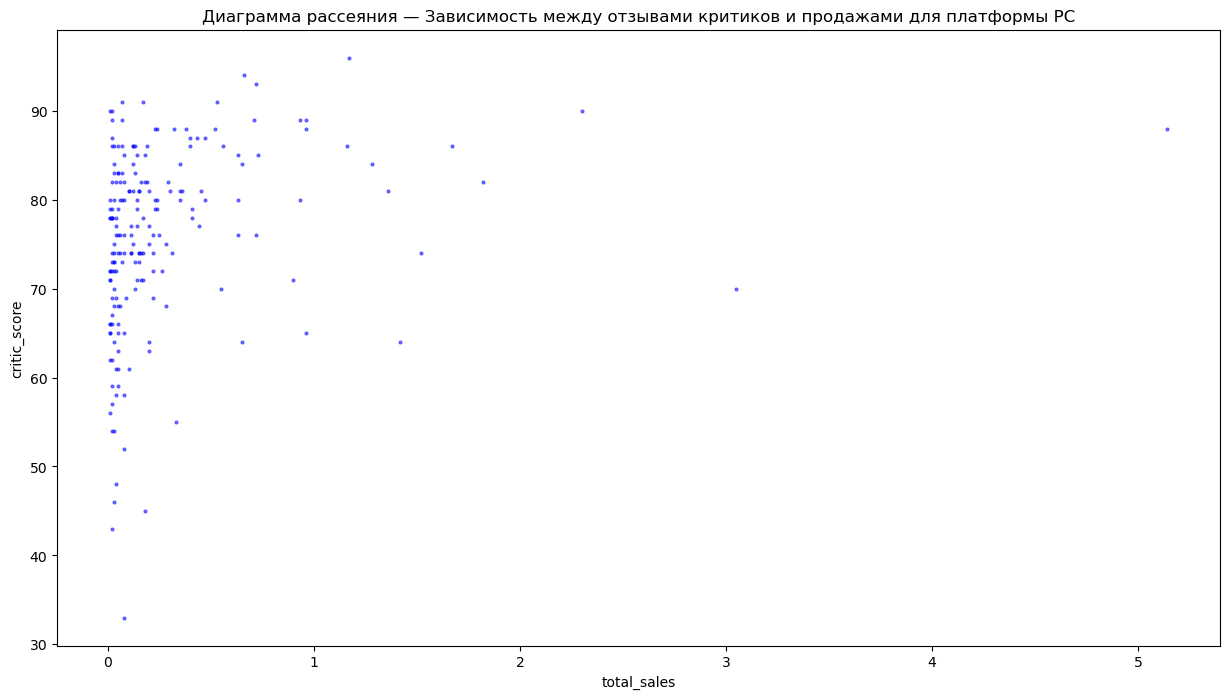

In [29]:
actual_platform_PC.plot(kind='scatter',
        y='critic_score' , x='total_sales', alpha=0.5, subplots=True, figsize=(15,8), c = 'b', s = 4)
plt.title('Диаграмма рассеяния — Зависимость между отзывами критиков и продажами для платформы PC');

Коэффициент получился равен 0,23 - очень слабый. Диаграмма рассеяния подтверждает утверждение,что отзывы критиков не оказывают существенного влияния на продажи для платформы PC. 

Повторим операцию, но уже для столбца рейтинг пользователей. 

In [30]:
actual_platform_PC['user_score'].corr(actual_period['total_sales'])

-0.12186747630735577

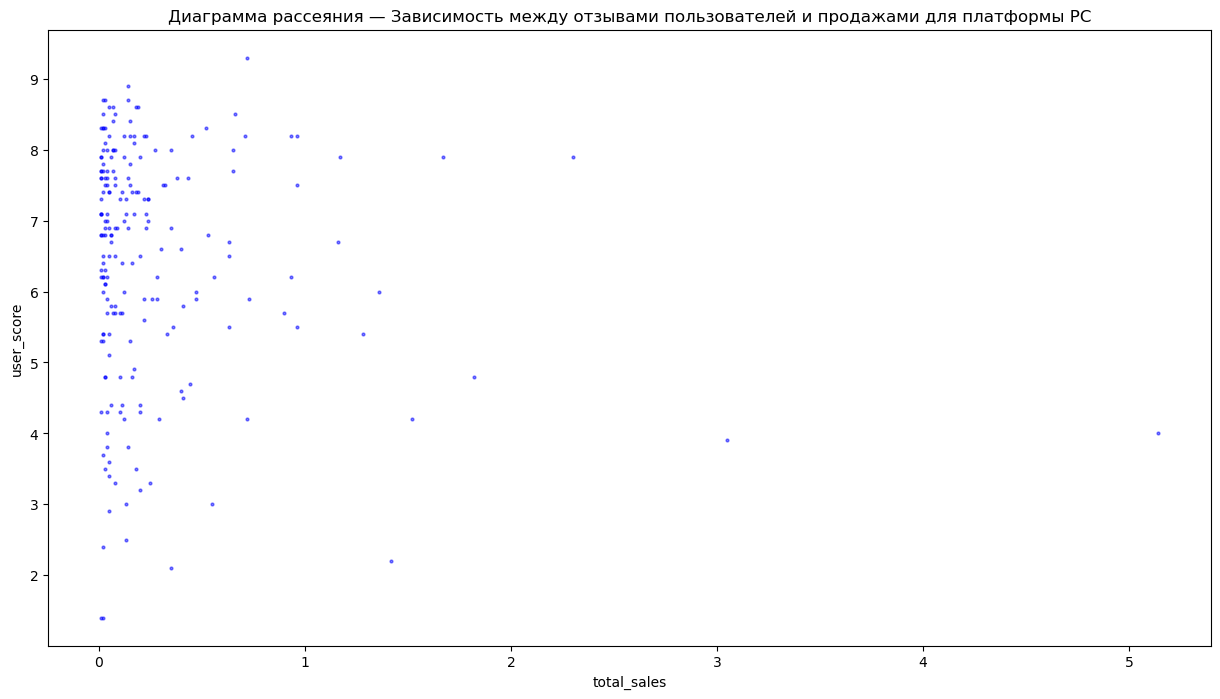

In [31]:
actual_platform_PC.plot(kind='scatter',
        y='user_score' , x='total_sales', alpha=0.5, subplots=True, figsize=(15,8), c = 'b', s = 4)
plt.title('Диаграмма рассеяния — Зависимость между отзывами пользователей и продажами для платформы PC');

Так как коэффициент корреляции оценивается по модулю то корреляция между отзывами пользователей и продажами составила 0,12 - очень слабая. Отзывы пользователей не оказывают существенного влияния на продажи для платформы PC.

#### Расчёт корреляции для платформы PS3.

Определим коэффициенты корреляции для платформы PS3. 

In [32]:
actual_platform_PS3['critic_score'].corr(actual_period['total_sales'])

0.3314972592629587

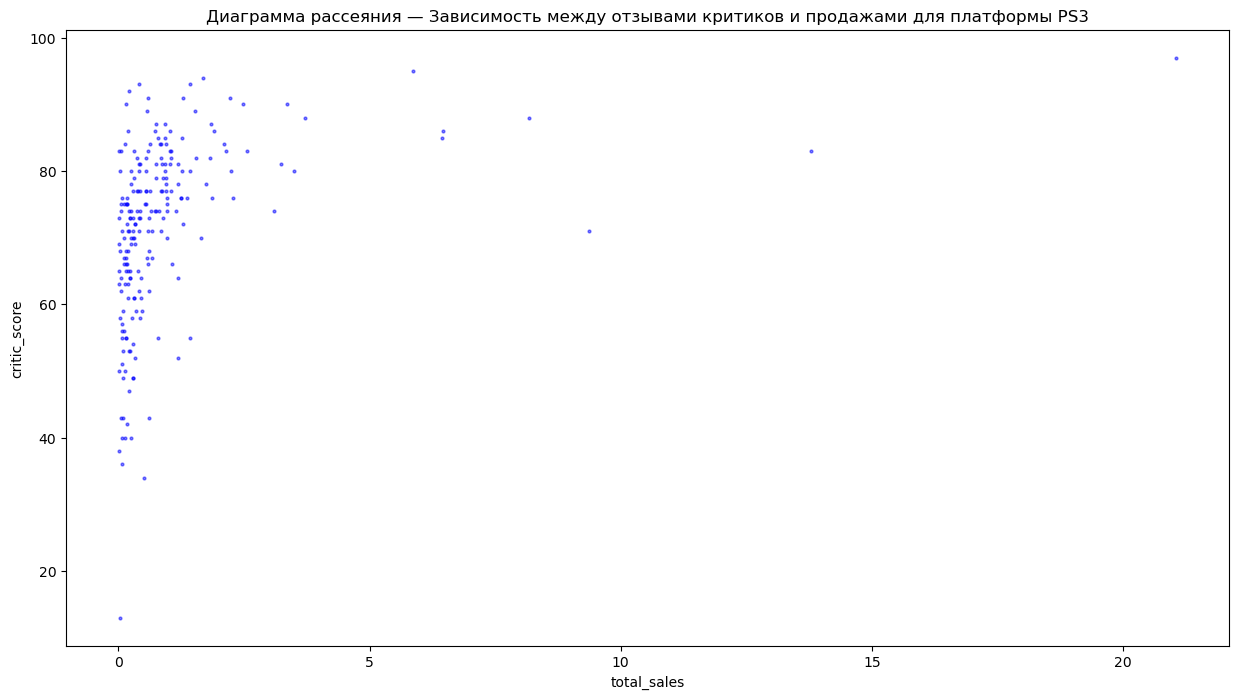

In [33]:
actual_platform_PS3.plot(kind='scatter',
        y='critic_score' , x='total_sales', alpha=0.5, subplots=True, figsize=(15,8), c = 'b', s = 4)
plt.title('Диаграмма рассеяния — Зависимость между отзывами критиков и продажами для платформы PS3');

Коэффициент получился равен 0,33 - слабый. Диаграмма рассеяния подтверждает утверждение,что отзывы критиков оказывают небольшое  влияние на продажи для платформы PC. 

In [34]:
actual_platform_PS3['user_score'].corr(actual_period['total_sales'])

-0.005143522887113828

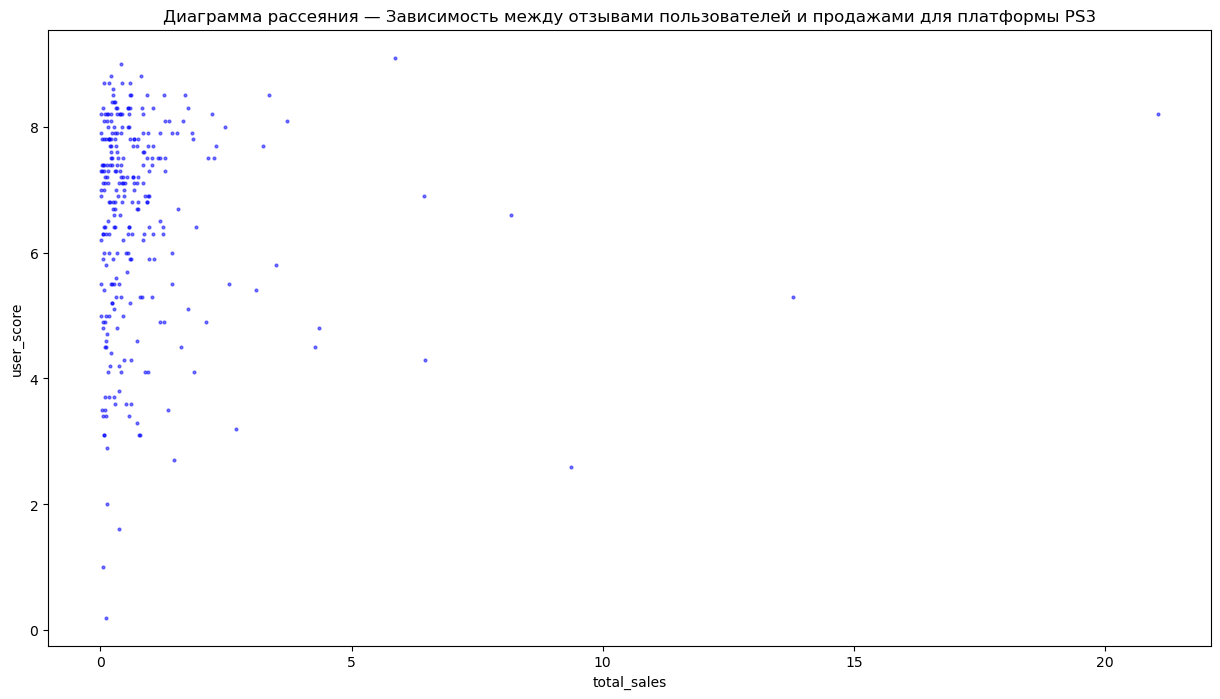

In [35]:
actual_platform_PS3.plot(kind='scatter',
        y='user_score' , x='total_sales', alpha=0.5, subplots=True, figsize=(15,8), c = 'b', s = 4)
plt.title('Диаграмма рассеяния — Зависимость между отзывами пользователей и продажами для платформы PS3');

Коэффициент корреляция отзывов пользователей и продажами для платформы PS3 равен 0.05 - очень слабый. 

#### Расчёт корреляции для платформы PS4.

Определим коэффициенты корреляции для платформы PS4. 

In [36]:
actual_platform_PS4['critic_score'].corr(actual_period['total_sales'])

0.40656790206178095

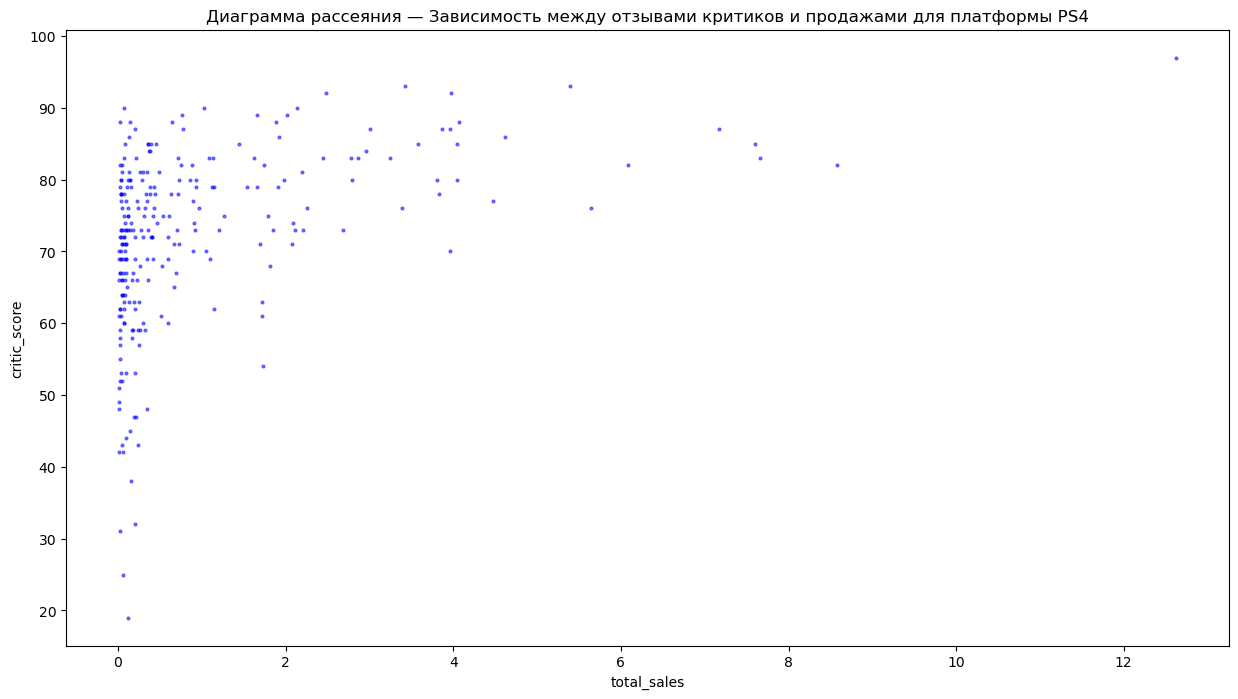

In [37]:
actual_platform_PS4.plot(kind='scatter',
        y='critic_score' , x='total_sales', alpha=0.5, subplots=True, figsize=(15,8), c = 'b', s = 4)
plt.title('Диаграмма рассеяния — Зависимость между отзывами критиков и продажами для платформы PS4');

Коэффициент корреляции равен 0,40 - слабый. На платформе PS4 отзывы критиков не оказывают существенного влияния на продажи. 

In [38]:
actual_platform_PS4['user_score'].corr(actual_period['total_sales'])

-0.031957110204556376

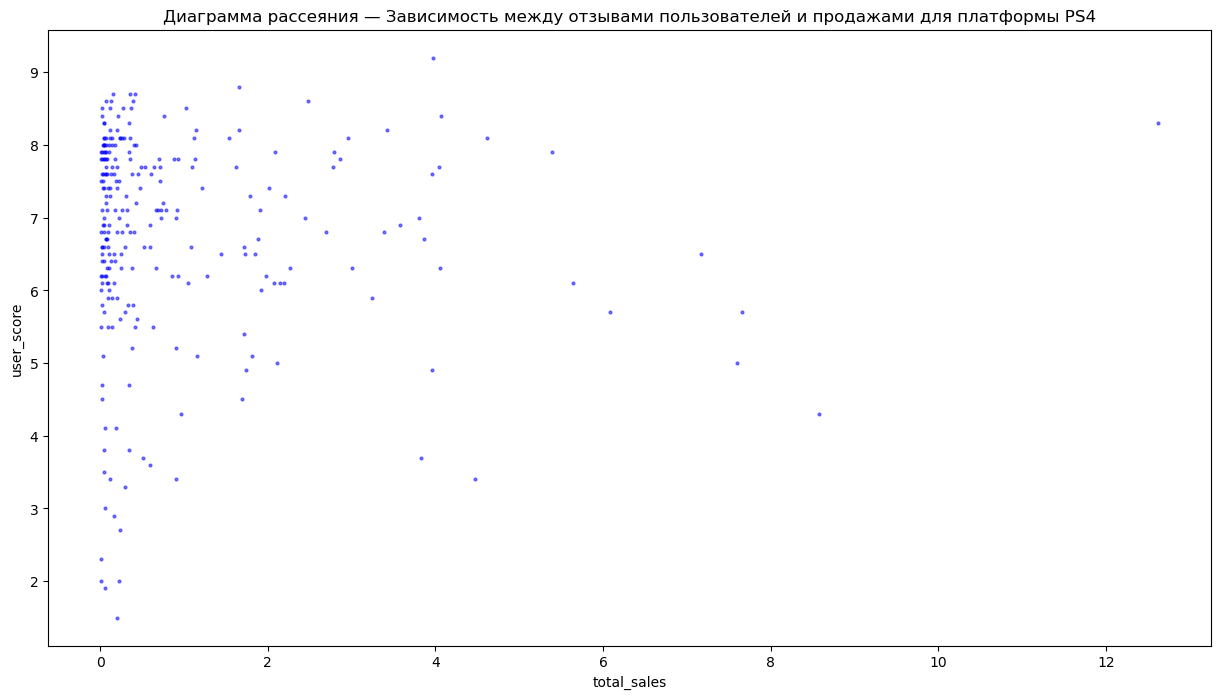

In [39]:
actual_platform_PS4.plot(kind='scatter',
        y='user_score' , x='total_sales', alpha=0.5, subplots=True, figsize=(15,8), c = 'b', s = 4)
plt.title('Диаграмма рассеяния — Зависимость между отзывами пользователей и продажами для платформы PS4');

Коэффициент корреляция отзывов пользователей и продажами для платформы PS4 равен 0.03 - очень слабый. 

#### Расчёт корреляции для платформы Wii.

Определим коэффициенты корреляции для платформы Wii.

In [40]:
actual_platform_Wii['critic_score'].corr(actual_period['total_sales'])

-0.4243413011077494

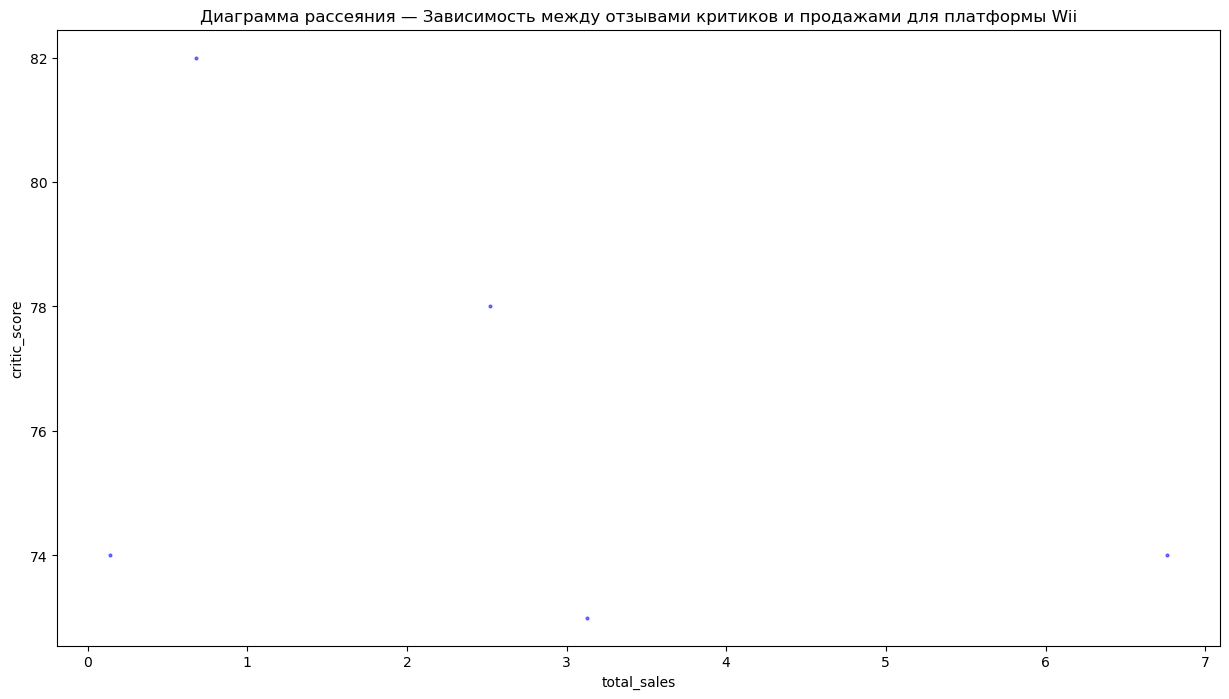

In [41]:
actual_platform_Wii.plot(kind='scatter',
        y='critic_score' , x='total_sales', alpha=0.5, subplots=True, figsize=(15,8), c = 'b', s = 4)
plt.title('Диаграмма рассеяния — Зависимость между отзывами критиков и продажами для платформы Wii');

Коэффициент корреляции равен 0,42 - слабый. На платформе Wii отзывы критиков не оказывают существенного влияния на продажи.

In [42]:
actual_platform_Wii['user_score'].corr(actual_period['total_sales'])

0.29619680007479526

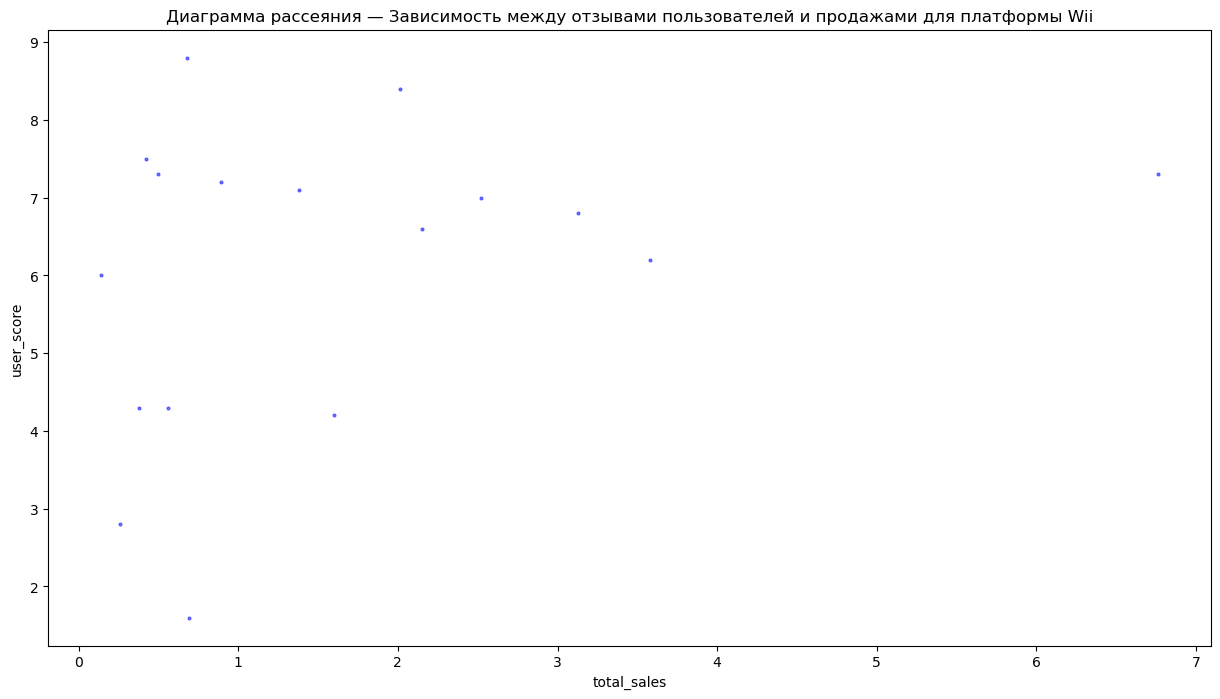

In [43]:
actual_platform_Wii.plot(kind='scatter',
        y='user_score' , x='total_sales', alpha=0.5, subplots=True, figsize=(15,8), c = 'b', s = 4)
plt.title('Диаграмма рассеяния — Зависимость между отзывами пользователей и продажами для платформы Wii');

Коэффициент корреляция отзывов пользователей и продажами для платформы Wii равен 0.29 - очень слабый.

#### Расчёт корреляции для платформы WiiU.

Определим коэффициенты корреляции для платформы WiiU.

In [44]:
actual_platform_WiiU['critic_score'].corr(actual_period['total_sales'])

0.34837976012017485

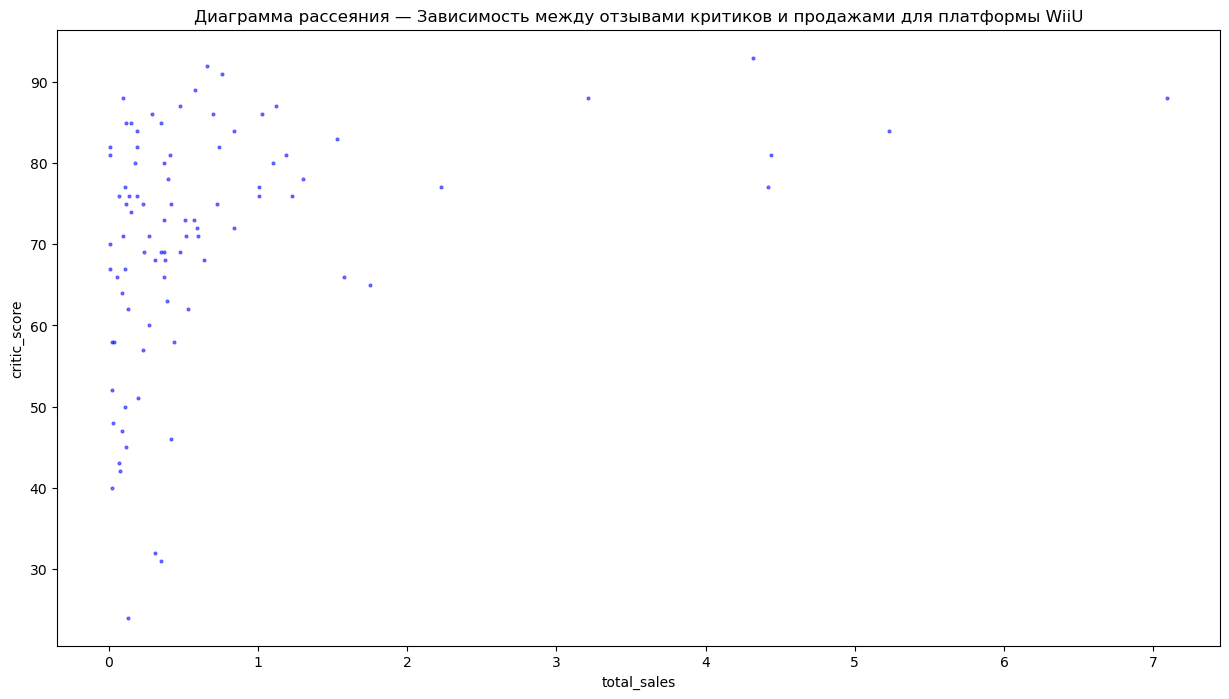

In [45]:
actual_platform_WiiU.plot(kind='scatter',
        y='critic_score' , x='total_sales', alpha=0.5, subplots=True, figsize=(15,8), c = 'b', s = 4)
plt.title('Диаграмма рассеяния — Зависимость между отзывами критиков и продажами для платформы WiiU');

Коэффициент корреляции равен 0,34 - слабый. На платформе WiiU отзывы критиков не оказывают существенного влияния на продажи.

In [46]:
actual_platform_WiiU['user_score'].corr(actual_period['total_sales'])

0.4002190202148617

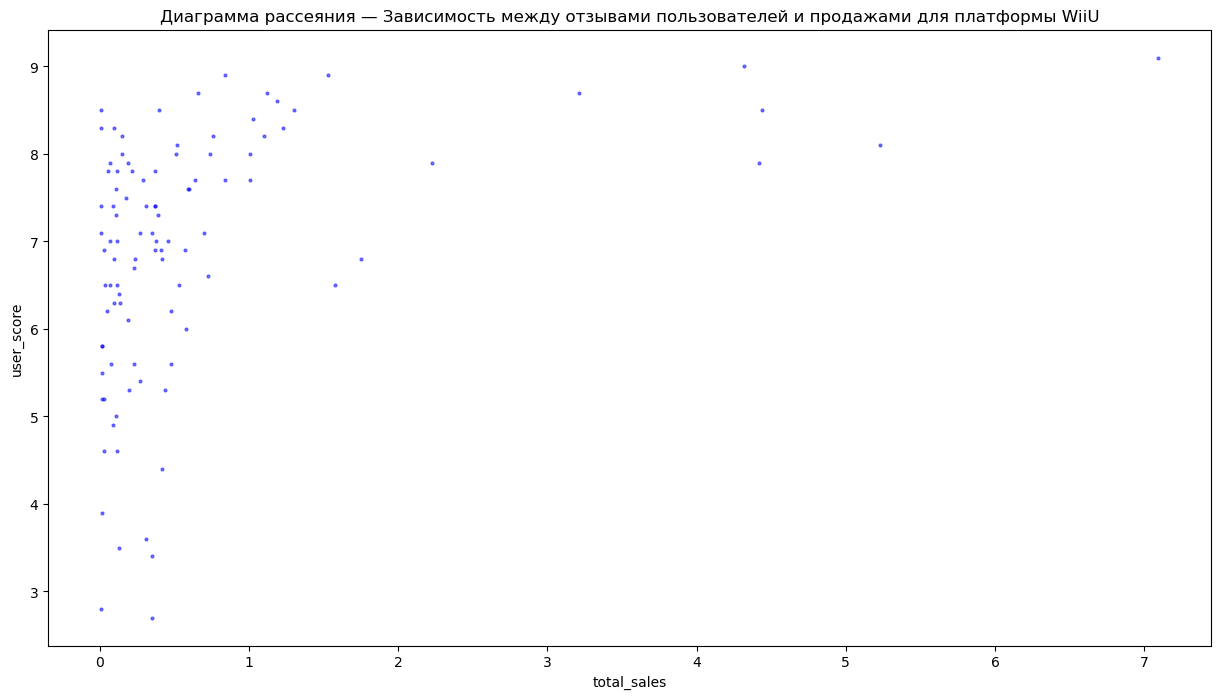

In [47]:
actual_platform_WiiU.plot(kind='scatter',
        y='user_score' , x='total_sales', alpha=0.5, subplots=True, figsize=(15,8), c = 'b', s = 4)
plt.title('Диаграмма рассеяния — Зависимость между отзывами пользователей и продажами для платформы WiiU');

Коэффициент корреляции равен 0,40 - слабый. На платформе WiiU отзывы пользователей не оказывают существенного влияния на продажи.

#### Расчёт корреляции для платформы X360.

Определим коэффициенты корреляции для платформы X360.

In [48]:
actual_platform_X360['critic_score'].corr(actual_period['total_sales'])

0.3605734888507336

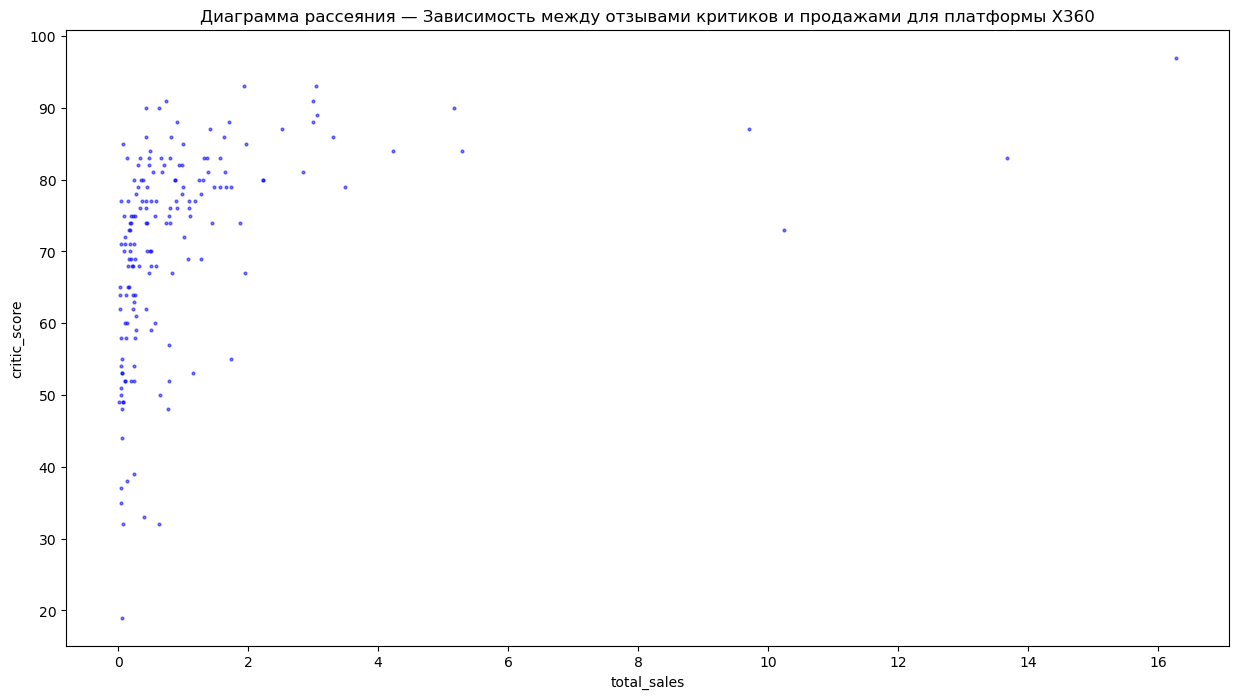

In [49]:
actual_platform_X360.plot(kind='scatter',
        y='critic_score' , x='total_sales', alpha=0.5, subplots=True, figsize=(15,8), c = 'b', s = 4)
plt.title('Диаграмма рассеяния — Зависимость между отзывами критиков и продажами для платформы X360');

Коэффициент корреляции равен 0,36 - слабый. На платформе X360 отзывы критиков не оказывают существенного влияния на продажи.

In [50]:
actual_platform_X360['user_score'].corr(actual_period['total_sales'])

0.006163978646213326

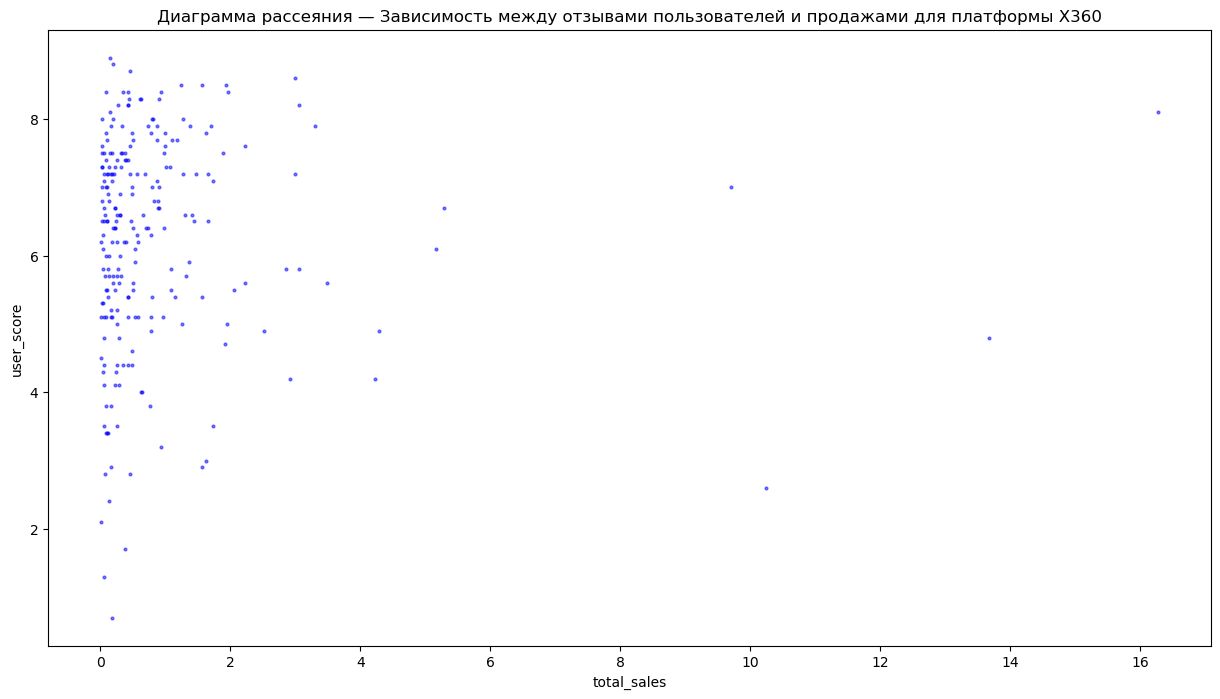

In [51]:
actual_platform_X360.plot(kind='scatter',
        y='user_score' , x='total_sales', alpha=0.5, subplots=True, figsize=(15,8), c = 'b', s = 4)
plt.title('Диаграмма рассеяния — Зависимость между отзывами пользователей и продажами для платформы X360');

Коэффициент корреляция отзывов пользователей и продажами для платформы X360 равен 0.006 - очень слабый.

#### Расчёт корреляции для платформы XOne.

Определим коэффициенты корреляции для платформы XOne.

In [52]:
actual_platform_XOne['critic_score'].corr(actual_period['total_sales'])

0.4169983280084017

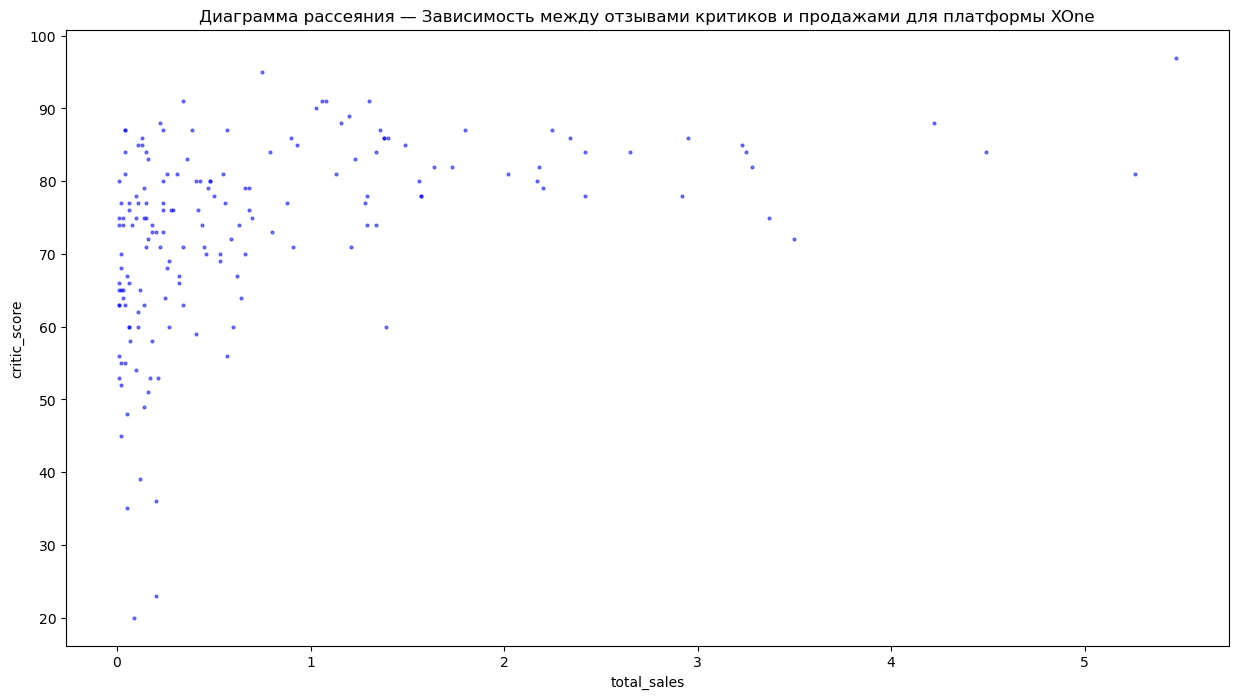

In [53]:
actual_platform_XOne.plot(kind='scatter',
        y='critic_score' , x='total_sales', alpha=0.5, subplots=True, figsize=(15,8), c = 'b', s = 4)
plt.title('Диаграмма рассеяния — Зависимость между отзывами критиков и продажами для платформы XOne');

Коэффициент корреляции равен 0,41 - слабый. На платформе XOne отзывы критиков не оказывают существенного влияния на продажи.

In [54]:
actual_platform_XOne['user_score'].corr(actual_period['total_sales'])

-0.06892505328279414

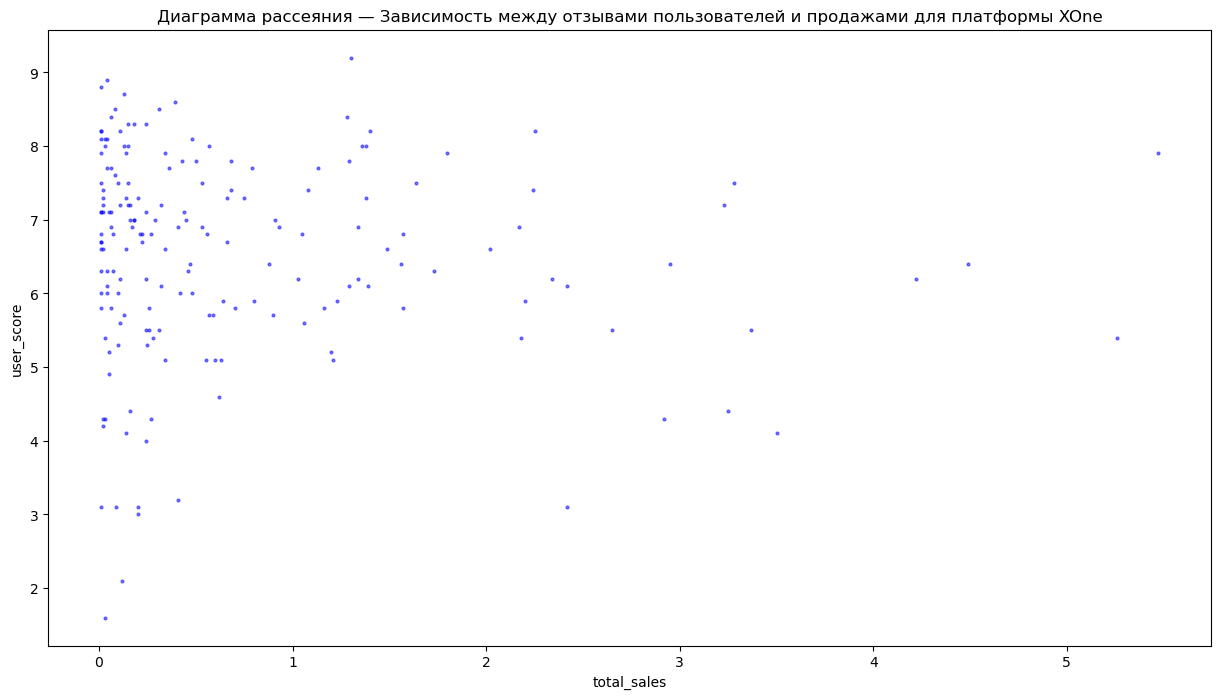

In [55]:
actual_platform_XOne.plot(kind='scatter',
        y='user_score' , x='total_sales', alpha=0.5, subplots=True, figsize=(15,8), c = 'b', s = 4)
plt.title('Диаграмма рассеяния — Зависимость между отзывами пользователей и продажами для платформы XOne');

Коэффициент корреляция отзывов пользователей и продажами для платформы XOne равен 0.06 - очень слабый.

Вывод по итогам вычисления корреляций:

Существенного влияния отзывы пользователей и критиков на продажи не оказывают. Вероятно на продажи оказывают влияние другие факторы. Исследование было проведенно для 6 самых популярных платформ за актуальный период времени (с 2012 по 2016 год).

### Самые популярные жанры игр.

Построим гистограмму для столбца genre. Проанализируем игр каких жанров было больше всего выпущено. 

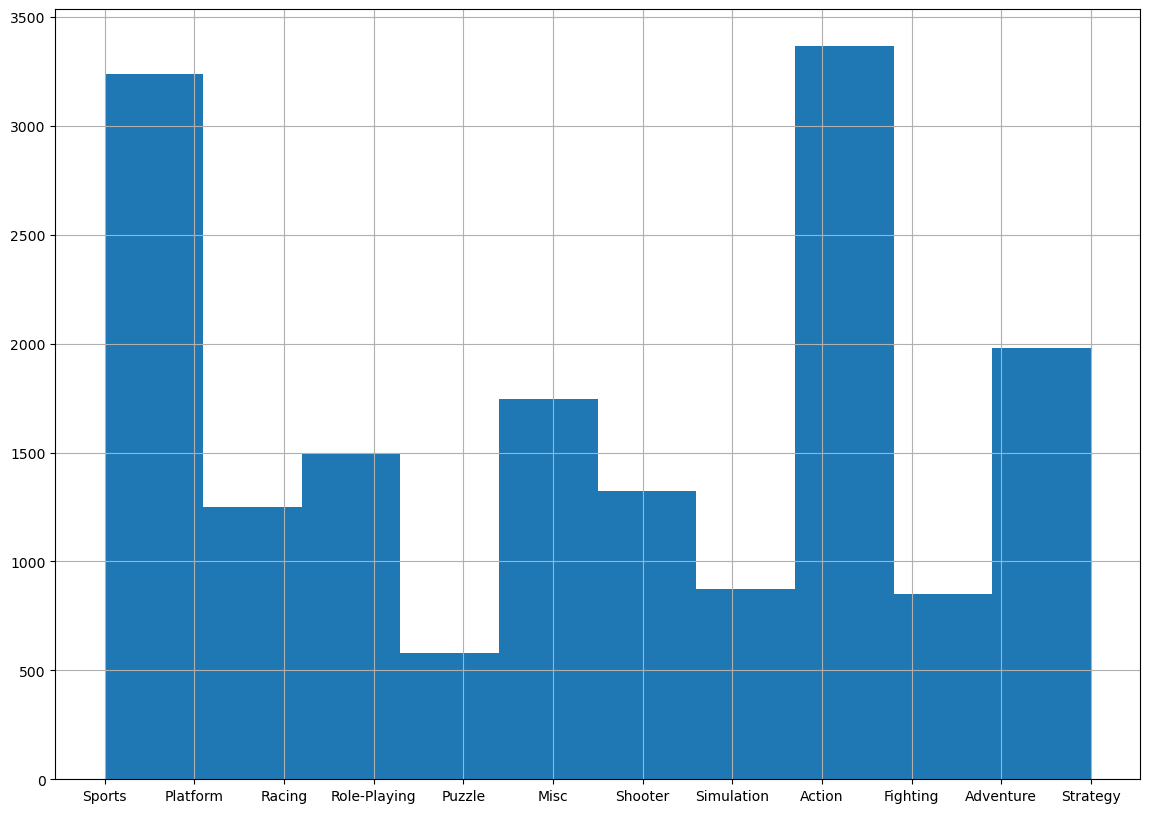

In [56]:
data['genre'].hist(figsize=(14, 10));

На гистограмме наблюдаем топ 3 самых популярных жанров: Action, sports и strategy.

Используем метод groupby рассчитаем среднее значение для определения наиболее успешных жанров игр. 

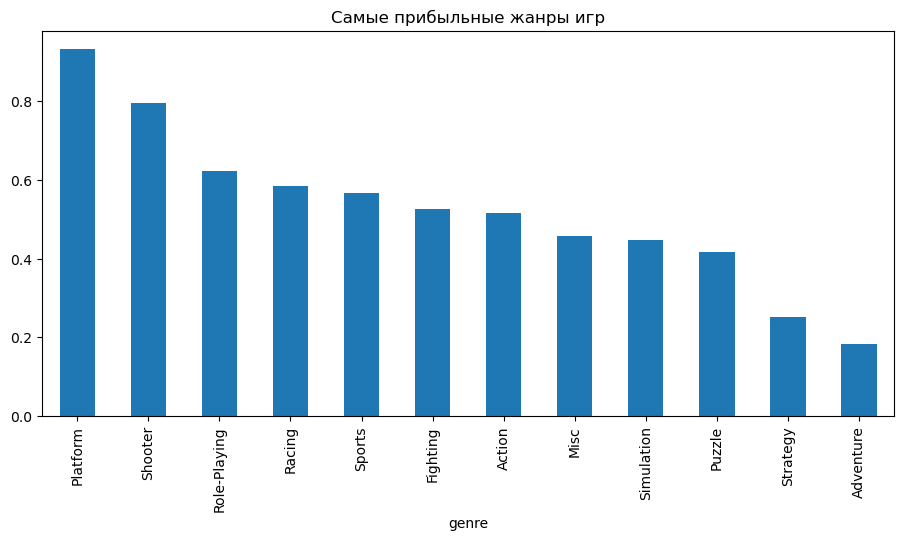

In [57]:
data.groupby('genre')['total_sales'].mean().sort_values(ascending=False).plot(figsize=(11,5),kind="bar",title='Самые прибыльные жанры игр');

ТОП самых прибыльных жанров: Platform, Shooter и Role-Playing. Наимение прибыльные жанры: Adventure, Stratery, Puzzle.

Интересно,что жанр strategy входит в ТОП 3 по количеству выпущенных игр, но приносит меньше денег чем остальные жанры.  

### Портрет пользователя каждого региона.

Попробуем составить портрет пользователя каждого региона. Для этого воспользуемся методом groupby и построим круговую диаграмму для пользователя из Северной Америки. 

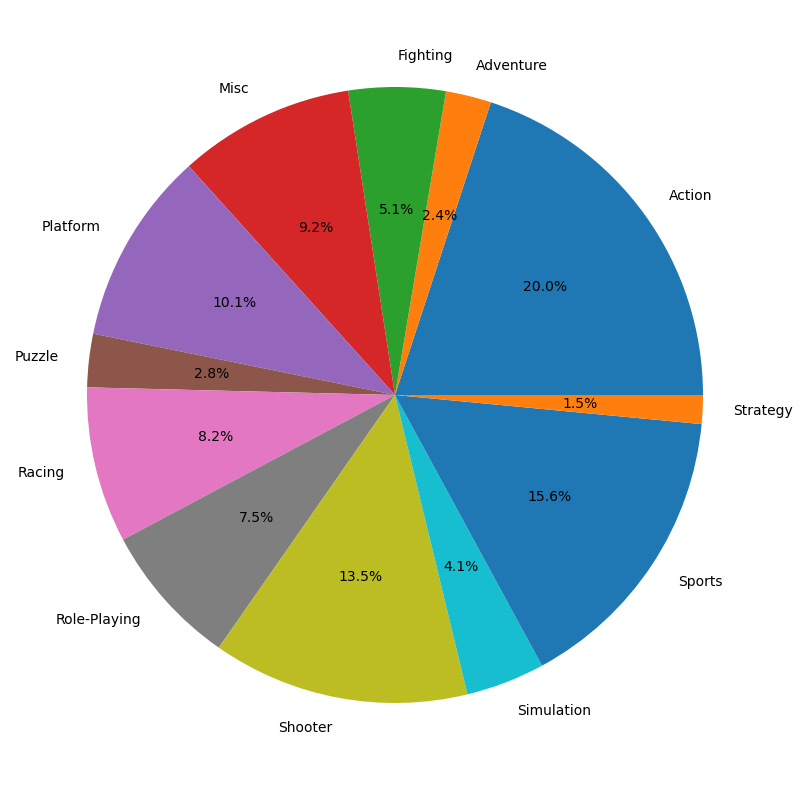

In [58]:
data_portraits = data.groupby('genre')[['na_sales', 'eu_sales', 'jp_sales']].sum()
 

fig = plt.figure()
fig.set_size_inches(10,10)
data_pl_na = data_portraits['na_sales']
my_labels = list(data_portraits.index)
plt.pie(data_pl_na,labels=my_labels,autopct='%1.1f%%')
plt.show()

На диаграмме видны предпочтения игрока из Северной Америки. ТОП 5 жанров: Action - 20,0%, Sports- 15,6%, Shooter - 13,5%, Platform - 10,1%, Misc - 9,3%.

Повторим алгоритм для игрока из Европы. 

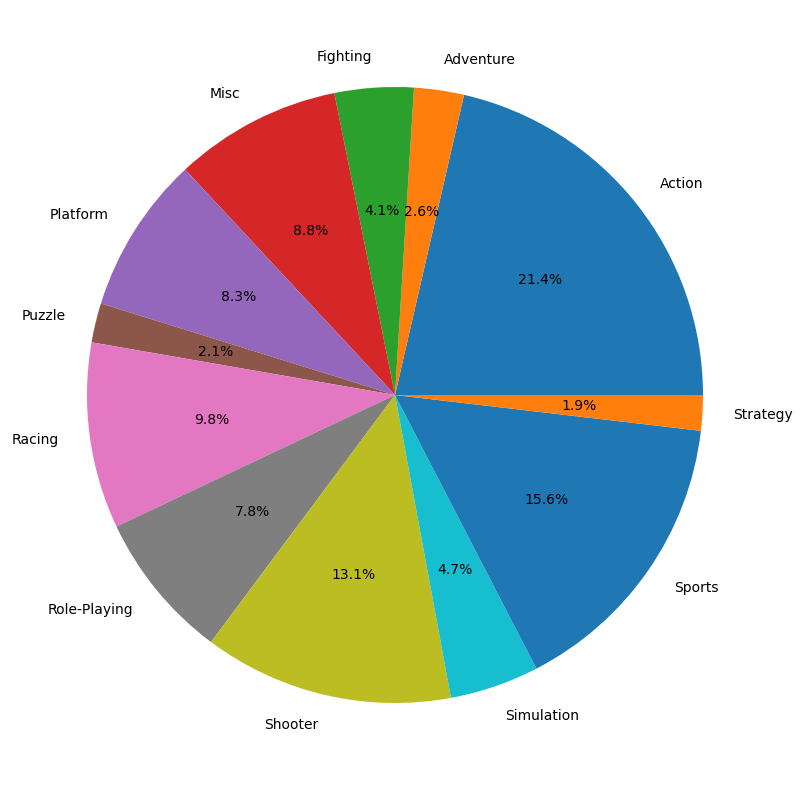

In [59]:
fig = plt.figure()
fig.set_size_inches(10,10)
data_pl_eu = data_portraits['eu_sales']
my_labels = list(data_portraits.index)
plt.pie(data_pl_eu,labels=my_labels,autopct='%1.1f%%')
plt.show()

Основное отличие у Европейского игрока - это наличие в топе жанра racing: Action - 21,4%, Sports - 15,5%, Shooter - 13,1% , Racing - 9,8%, Misc - 8,8 % Повторим тоже самое для игрока из Японии.

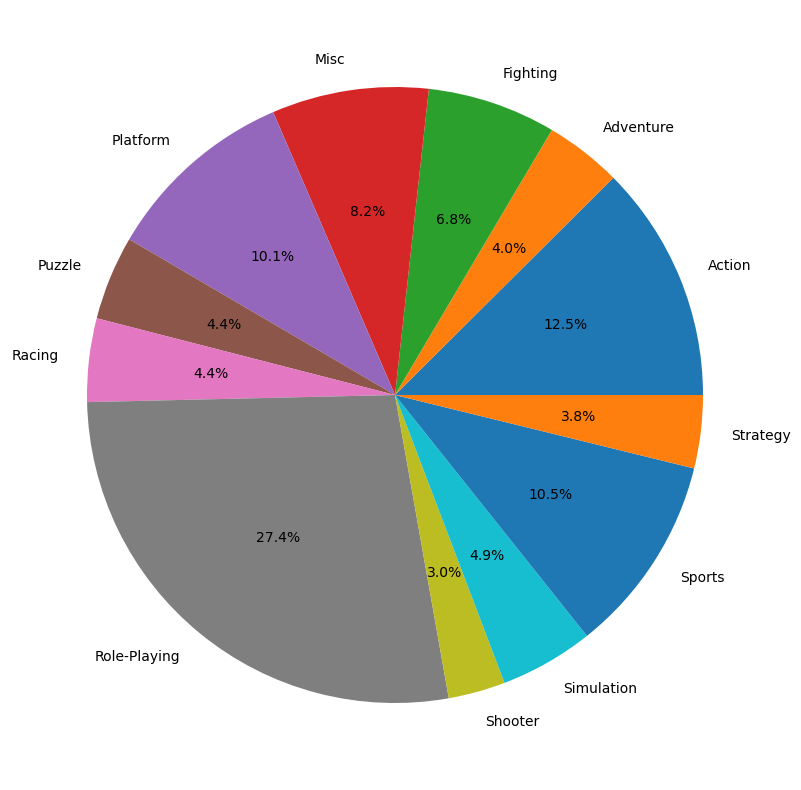

In [60]:
fig = plt.figure()
fig.set_size_inches(10,10)
data_pl_jp = data_portraits['jp_sales']
my_labels = list(data_portraits.index)
plt.pie(data_pl_jp,labels=my_labels,autopct='%1.1f%%')
plt.show()

Здесь уже кардинальные отличия: Role-Playing - 27,4%, Action - 12,4%, Sports - 10,4%, Platform - 10,1%, Misc - 8,3%.  

Построим столбчатую диаграмму для рынка Северной Америки и определим ТОП платформ по уровню продаж. 

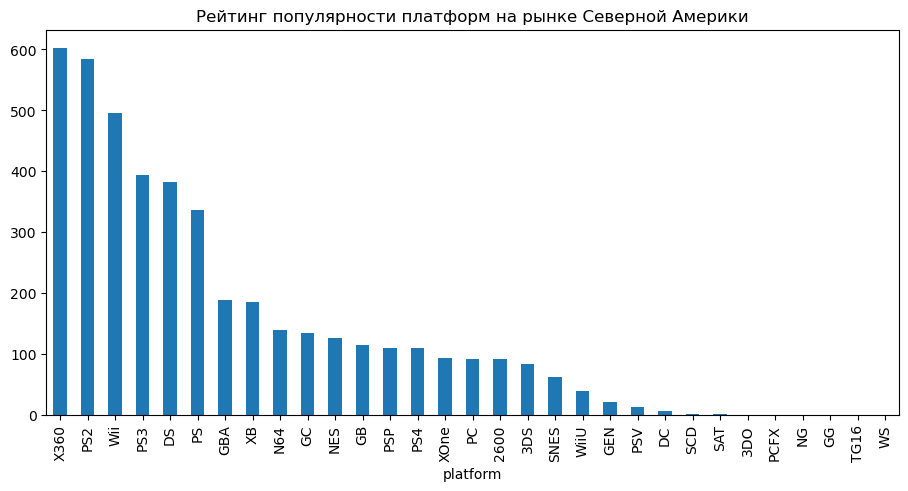

In [61]:
data.groupby('platform')['na_sales'].sum().sort_values(ascending=False).plot(figsize=(11,5),kind="bar",title='Рейтинг популярности платформ на рынке Северной Америки');

На рынке Северной Америки ТОП 5 платформ выглядит следующим образом: X360, PS2, Wii, PS3, DS.

Построим аналогичную диаграмму для рынка Европы. 

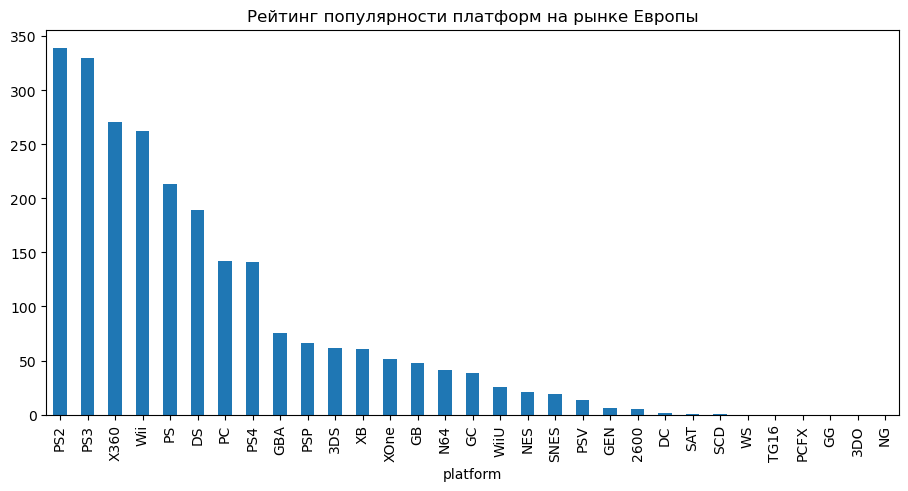

In [62]:
data.groupby('platform')['eu_sales'].sum().sort_values(ascending=False).plot(figsize=(11,5),kind="bar",title='Рейтинг популярности платформ на рынке Европы');

ТОП платформ для рынка Европы выглядит следующим образом: PS2, PS3, X360, Wii, PS.

Построим диаграмму для рынка Японии.

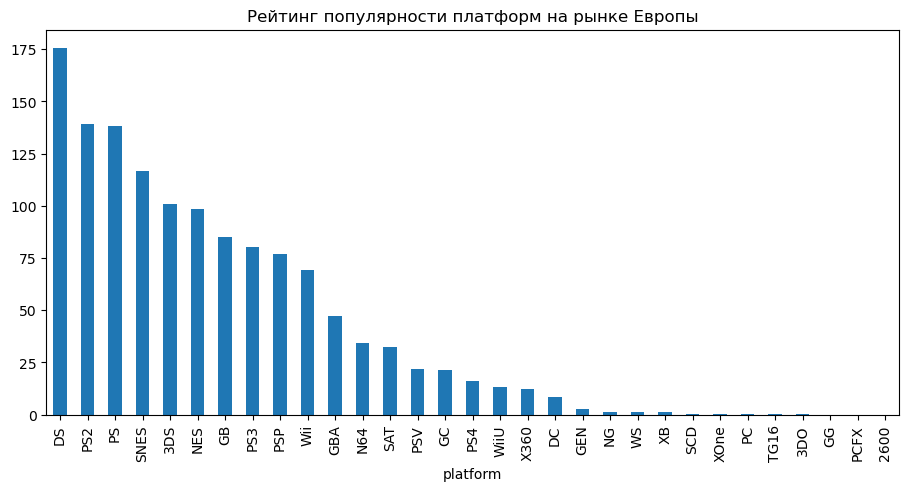

In [63]:
data.groupby('platform')['jp_sales'].sum().sort_values(ascending=False).plot(figsize=(11,5),kind="bar",title='Рейтинг популярности платформ на рынке Европы');

ТОП платформ для рынка Японии выглядит следующим образом: DS, PS2, PS, SNES, 3DS.

Построим диаграмму для рынка Северной Америки и посмотрим как рейтинг ESRB влияет на продажи.

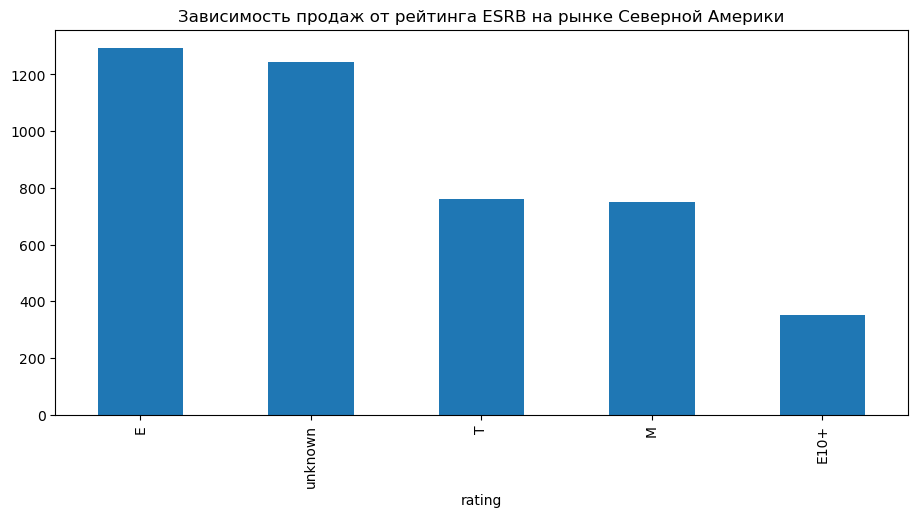

In [64]:
data.groupby('rating')['na_sales'].sum().sort_values(ascending=False).plot(figsize=(11,5),kind="bar",title='Зависимость продаж от рейтинга ESRB на рынке Северной Америки');

Больше всего денег принесли игры с рейтингом «E» («Everyone») — «Для всех», на втором месте игры с неопределенной возрастной категорией (unknown), на третьем и четвертом месте игры с рейтингом «T» («Teen») — «Подросткам и «M» («Mature») — «Для взрослых». 

Построим аналогичную диаграмму для рынка Европы. 

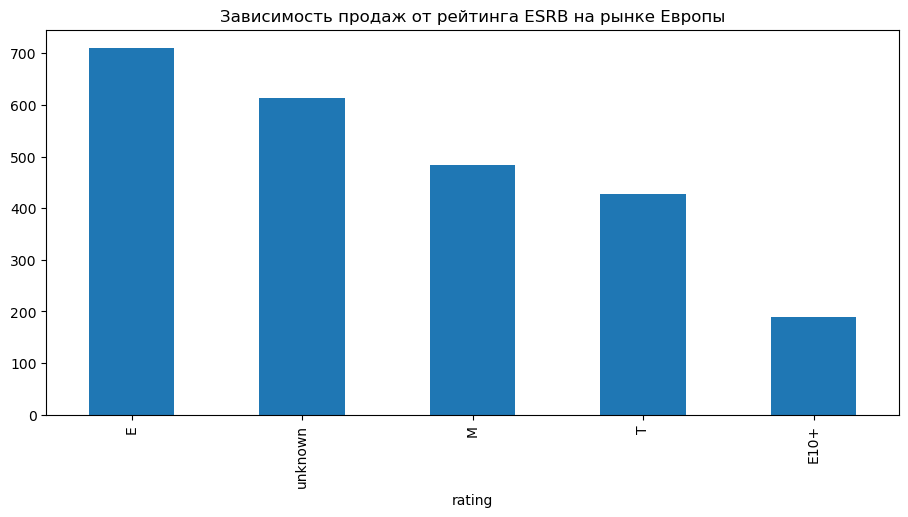

In [65]:
data.groupby('rating')['eu_sales'].sum().sort_values(ascending=False).plot(figsize=(11,5),kind="bar",title='Зависимость продаж от рейтинга ESRB на рынке Европы');

На первом месте игры с рейтингом «E» («Everyone») — «Для всех», на втором месте игры с неопределенной возрастной категорией (unknown), на третьем «M» («Mature») — «Для взрослых». Как видно на рынке Европы присутствует небольшое перераспределение в пользу более взрослых геймеров. 

Построим диаграмму для рынка Японии.

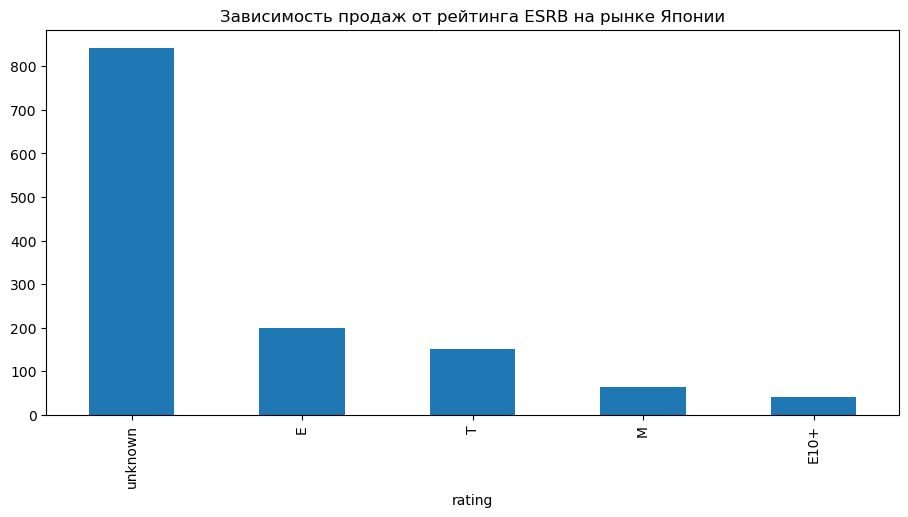

In [66]:
data.groupby('rating')['jp_sales'].sum().sort_values(ascending=False).plot(figsize=(11,5),kind="bar",title='Зависимость продаж от рейтинга ESRB на рынке Японии');

На рынке Японии с большим отрывом лидируют игры в которых возрастной рейтинг не определен (unknown). На втором месте игры с рейтингом «E» («Everyone») — «Для всех». На третьем месте игры с рейтингом «T» («Teen») — «Подросткам. Вероятно такая особенность обусловлена наличием в Японии своей собственной организации, которая присваивает рейтинг играм (CERO - Computer Entertainment Rating Organization).

### Проверка гипотез.

Сформулируем и проверим две гипотезы.

Проверим первую гипотезу. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Для этого воспользуемся инструментом ttest_ind. Нулевая гипотеза заключается в том,что рейтинги для двух платформ будут равны, если гипотеза отвергнута, то рейтинги различаются. Зададим пороговое значение alpha равное 0.05. 

In [67]:
actual_period = actual_period.dropna(subset=['user_score'])

xbox_one= actual_period.loc[actual_period['platform']=='XOne']['user_score']
pc = actual_period.loc[actual_period['platform']=='PC']['user_score']

alpha = 0.05
results = st.ttest_ind(xbox_one, pc)
print(results.pvalue)
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.5535080500643661
Не получилось отвергнуть нулевую гипотезу


Гипотезу отвергнуть не удалось. Получается, что рейтинги платформ Xbox One и PC одинаковые.

Проверим вторую гипотезу. Средние пользовательские рейтинги жанров Action и Sports разные. Вновь воспользуемся инструментом ttest_ind. Нулевую гипотезу сформируем так:  пользовательские оценки жанров action и sports одинаковые. Если данная гипотеза отвергается, то получается что пользовательские оценки для данных жанров разные. 

In [68]:
action = actual_period.loc[actual_period['genre']=='Action']['user_score']
sports = actual_period.loc[actual_period['genre']=='Sports']['user_score']
 
alpha = 0.05
results = st.ttest_ind(action, sports)
print(results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

3.7163089460934874e-26
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергнута в результате теста, а значит пользовательские оценки для жанра action и sports действительно различаются.

## Общий вывод по проекту.

В данном проекте был проведен анализ датасета по продажам видеоигр за период с 1980 по 2016 год.
Основные тезисы, которые были сделаны в рамках данного проекта:

1) Как видно на гистограмме индустрия разработки компьютерных игр начала ускоренный рост в конце 90х годов и достигла своего пика в 2010-2012. Далее произошел спад в два раза. 

2) Средний срок жизни платформы составляет ~ 10 лет. Основная особенность что пика продаж платформа достигает в первые 5 лет, далее идёт спад и завершение цикла жизни платформы. Исключением является PC, так как это не только платформа для игр , но и универсальный инструмент для работы и мультимедиа.

3) Топ 3 самых прибыльных платформ за период с 2012 по 2016 год: PS4, PS3, X360.

4) Рейтинги игроков и критиков не оказывают существенного влияния на продажи. Вероятно на продажи влияют другие факторы (реклама либо само качество видеоигры).

5) Между рынками Америки, Европы и Японии существуют отличия. Игроки из Америки и Европы больше предпочитают игры жанров Action, shooter и sports. Игроки из Японии отдают предпочтение Role-playing играм. 

6) Продажи платформ сильно зависят от региона. 
На рынке Северной Америки популярностью пользуются: X360, PS2, Wii, PS3, DS.
На рынке Европы: PS2, PS3, X360, Wii, PS.
В Японии: DS, PS2, PS, SNES, 3DS.

7) Самые прибыльные жанры игр. 
ТОП самых прибыльных жанров: Platform, Shooter и Role-Playing. Наимение прибыльные жанры: Adventure, Stratery, Puzzle.

Интересно,что жанр strategy входит в ТОП 3 по количеству выпущенных игр, но приносит меньше денег чем остальные жанры.

8) На продажи влияет рейтинг ESRB. 
Первое место на рынках Северной Америки и Европы занимают игры с возрастным ограничением  «E» («Everyone») — «Для всех».
На рынке Японии на первом месте игры с неопределенной категорией (unknown). 

9) Были проверены две гипотезы. 

Рейтинги популярности платформ Xbox One и PC одинаковые. 

Пользовательские оценки для жанра action и sports различаются.